In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, Comparator, SamplingMethod, plot_loss_df, set_seeds

In [ ]:
latex_var_map = {
    r"J_e": "Je",
    r"J_h": "Jh",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "Phi",
    r"\hat{c}_e": "ce",
    r"\hat{c}_h": "ch",

    r"\mu_{ae}": "muae",
    r"\sigma_{ae}": "sigae",
    r"\theta_e": "thetae",
    r"\theta_h": "thetah",
    r"\sigma^{q,k}": "sigqk",
    r"\sigma^{q,a}": "sigqa",
    r"\sigma^{q,k,1}": "sigsigqk",
    r"\sigma^{z,k}": "sigzk",
    r"\sigma^{z,a}": "sigza",
    r"\sigma_e^{J,k}": "sigJe_k",
    r"\sigma_h^{J,k}": "sigJh_k",
    r"\sigma_e^{J,a}": "sigJe_a",
    r"\sigma_h^{J,a}": "sigJh_a",

    r"\zeta_e^k": "zetae_k",
    r"\zeta_e^a": "zetae_a",
    r"\zeta_h^k": "zetah_k",
    r"\zeta_h^a": "zetah_a",
    r"\zeta_e^1": "zetae_1",
    r"\zeta_e^2": "zetae_2",
    r"\zeta_h^1": "zetah_1",
    r"\zeta_h^2": "zetah_2",
    r"\epsilon_e": "epse",
    r"\epsilon_h": "epsh",

    r"\mu^z": "muz",
    r"\mu^q": "muq",
    r"\mu_e^J": "muJe",
    r"\mu_h^J": "muJh",
    r"\mu_e^R": "muRe",
    r"\mu_h^R": "muRh",

    r"\hat{a_e}": "aebar",
    r"a_e": "ae",
    r"a_h": "ah",
    r"\sigma": "sig",
    r"\delta": "delta",
    r"\kappa": "kappa",
    r"\phi": "phi",
    r"\gamma": "gamma",
    r"\rho": "rho",
    r"\lambda_d": "lambdad",
    r"\underline{\chi}": "chi_a",
    r"\chi": "chi",
    r"\bar{z}": "zbar",
}

vars_to_plot = ["q", "thetae", "thetah", "psi", "sigsigqk", "sigqa", "epse", "epsh",
                "zmuz", "zsigzk", "zsigza", "zetae_k", "zetae_a", "zetah_k", "zetah_a"]
plot_args = {
    "q": {"ylabel": r"$q$", "title": r"Price"},
    "thetae": {"ylabel": r"$\theta_e$", "title": r"Portfolio Choice: Experts"},
    "thetah": {"ylabel": r"$\theta_h$", "title": r"Portfolio Choice: Households"},
    "psi": {"ylabel": r"$\psi$", "title": r"Capital Share: Experts"},
    "sigsigqk": {"ylabel": r"$\sigma+\sigma^{q,k}$", "title": r"Price return diffusion (capital shock)"},
    "sigqa": {"ylabel": r"$\sigma^{q,a}$", "title": r"Price return diffusion (productivity shock)"},
    "zmuz": {"ylabel": r"$z\mu^z$", "title": r"Drift of wealth share: Experts"},
    "zsigzk": {"ylabel": r"$z\sigma^{z,k}$", "title": r"Diffusion of wealth share (capital shock)"},
    "zsigza": {"ylabel": r"$z\sigma^{z,a}$", "title": r"Diffusion of wealth share (productivity shock)"},
    "zetae_k": {"ylabel": r"$\zeta_e^k$", "title": r"Experts price of risk: capital shock"},
    "zetae_a": {"ylabel": r"$\zeta_e^a$", "title": r"Experts price of risk: productivity shock"},
    "zetah_k": {"ylabel": r"$\zeta_h^k$", "title": r"Households price of risk: capital shock"},
    "zetah_a": {"ylabel": r"$\zeta_h^a$", "title": r"Households price of risk: productivity shock"}
}

z_min = 0.01
z_max = 0.99
a_min = 0.1
a_max = 0.2
ae_bar = (a_min + a_max) / 2
a_list = [a_min, ae_bar, a_max]
params = {
    "ah": 0.03,
    "sig": 0.1,
    "delta": 0.05,
    "kappa": 5,
    "phi": 0.5,
    "gamma": 5,
    "rho": torch.tensor(0.05),
    "lambdad": 0.03,
    "zbar": 0.1,
    "chi_a": 1,
    "v": 2.5,
    "p": 0.01,
    "fl": a_min,
    "fu": a_max,
    "aebar": ae_bar,
}

base_model_dir = "./models/cd_2d_timestep_random_sampling/"

In [ ]:
def compute_func(pde_model: PDEModelTimeStep, a_list, z_min, z_max, vars_to_plot):
    N = 100
    res_dict = {}
    for a in a_list:
        SV = torch.zeros((N, 3), device=pde_model.device)
        SV[:, 0] = torch.linspace(z_min, z_max, N)
        SV[:, 1] = torch.ones((N,)) * a
        x_plot = SV[:, 0].detach().cpu().numpy().reshape(-1)
        for i, sv_name in enumerate(pde_model.state_variables):
            pde_model.variable_val_dict[sv_name] = SV[:, i:i+1]
        pde_model.update_variables(SV)
        res_dict["x_plot"] = x_plot
        for var in vars_to_plot:
            if var in pde_model.variable_val_dict:
                res_dict[f"{var}_{a}"] = pde_model.variable_val_dict[var].detach().cpu().numpy().reshape(-1)
            elif var == "psi":
                res_dict[f"psi_{a}"] = np.ones(N)
    return res_dict

def plot_res(res_dict: dict, plot_args:dict, a_list):
    res_dict = res_dict.copy()
    x_plot = res_dict.pop("x_plot")
    x_label = "Wealth share (z)"
    total_plots = len(plot_args)
    cols = 4
    rows, rem = np.divmod(total_plots, cols)
    if rem > 0:
        rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*6))
    for i, (func_name, plot_arg) in enumerate(plot_args.items()):
        r, c = np.divmod(i, cols)
        curr_ax = axes[r, c] # hopefully we don't have only one row...
        for a in a_list:
            y_vals = res_dict[f"{func_name}_{a}"]
            curr_ax.plot(x_plot, y_vals, label=r"$a_e$={i}".format(i=str(round(a,2))))
        curr_ax.set_xlabel(x_label)
        curr_ax.set_ylabel(plot_arg["ylabel"])
        curr_ax.set_title(plot_arg["title"])
        curr_ax.legend()
    plt.show()

## Region 1
$\psi < 1$

============================Summary of Model cd2d_ts============================
Config: {
 "batch_size": 500,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "UniformRandom",
 "time_batch_size": 10,
 "boundary_grid_size": null
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zeta_h^a

Total loss: 0.0026: 100%|██████████| 5000/5000 [17:46<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.83944, Absolute Change: 0.16056, Relative Change:  0.16056
Jh: Mean Value: 0.83423, Absolute Change: 0.16577, Relative Change:  0.16577
q: Mean Value: 1.41651, Absolute Change: 0.41956, Relative Change:  0.41956
psi: Mean Value: 1.09572, Absolute Change: 0.37425, Relative Change:  0.37425
Updating min loss from inf to 0.0025
Outer Loop 0 Finished in 1066.4707s. Loading best model...


Total loss: 0.0002: 100%|██████████| 3535/3535 [12:33<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.71643, Absolute Change: 0.12301, Relative Change:  0.15027
Jh: Mean Value: 0.70595, Absolute Change: 0.12828, Relative Change:  0.15451
q: Mean Value: 1.41221, Absolute Change: 0.01113, Relative Change:  0.00791
psi: Mean Value: 1.08660, Absolute Change: 0.01617, Relative Change:  0.01851
Updating min loss from 0.0025 to 0.0002
Outer Loop 1 Finished in 753.8007s. Loading best model...


Total loss: 0.0002: 100%|██████████| 2886/2886 [10:09<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.61747, Absolute Change: 0.09896, Relative Change:  0.14388
Jh: Mean Value: 0.60304, Absolute Change: 0.10291, Relative Change:  0.14694
q: Mean Value: 1.41462, Absolute Change: 0.00965, Relative Change:  0.00662
psi: Mean Value: 1.06361, Absolute Change: 0.02478, Relative Change:  0.02430
Updating min loss from 0.0002 to 0.0001
Outer Loop 2 Finished in 609.4784s. Loading best model...


Total loss: 0.0003: 100%|██████████| 2500/2500 [08:46<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.53704, Absolute Change: 0.08043, Relative Change:  0.13699
Jh: Mean Value: 0.51922, Absolute Change: 0.08382, Relative Change:  0.14038
q: Mean Value: 1.41178, Absolute Change: 0.01291, Relative Change:  0.00897
psi: Mean Value: 1.03802, Absolute Change: 0.02824, Relative Change:  0.02570
Updating min loss from 0.0001 to 0.0001
Outer Loop 3 Finished in 526.9516s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2236/2236 [07:47<00:00,  4.78it/s]


Model loaded
Je: Mean Value: 0.47108, Absolute Change: 0.06596, Relative Change:  0.12992
Jh: Mean Value: 0.45034, Absolute Change: 0.06888, Relative Change:  0.13425
q: Mean Value: 1.40482, Absolute Change: 0.01034, Relative Change:  0.00734
psi: Mean Value: 1.01925, Absolute Change: 0.02374, Relative Change:  0.02272
Updating min loss from 0.0001 to 0.0000
Outer Loop 4 Finished in 467.4528s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2041/2041 [07:08<00:00,  4.76it/s]


Model loaded
Je: Mean Value: 0.41593, Absolute Change: 0.05515, Relative Change:  0.12440
Jh: Mean Value: 0.39307, Absolute Change: 0.05727, Relative Change:  0.12887
q: Mean Value: 1.40242, Absolute Change: 0.00494, Relative Change:  0.00345
psi: Mean Value: 1.00310, Absolute Change: 0.01740, Relative Change:  0.01840
Updating min loss from 0.0000 to 0.0000
Outer Loop 5 Finished in 428.7978s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1889/1889 [06:35<00:00,  4.78it/s]


Model loaded
Je: Mean Value: 0.36886, Absolute Change: 0.04707, Relative Change:  0.12018
Jh: Mean Value: 0.34477, Absolute Change: 0.04830, Relative Change:  0.12476
q: Mean Value: 1.39535, Absolute Change: 0.00722, Relative Change:  0.00507
psi: Mean Value: 0.99325, Absolute Change: 0.01012, Relative Change:  0.01167
Updating min loss from 0.0000 to 0.0000
Outer Loop 6 Finished in 395.2294s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1767/1767 [06:14<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.32841, Absolute Change: 0.04045, Relative Change:  0.11650
Jh: Mean Value: 0.30402, Absolute Change: 0.04076, Relative Change:  0.12019
q: Mean Value: 1.39089, Absolute Change: 0.00459, Relative Change:  0.00327
psi: Mean Value: 0.98337, Absolute Change: 0.01040, Relative Change:  0.01266
Updating min loss from 0.0000 to 0.0000
Outer Loop 7 Finished in 374.1679s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1666/1666 [05:51<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.29396, Absolute Change: 0.03445, Relative Change:  0.11138
Jh: Mean Value: 0.26958, Absolute Change: 0.03444, Relative Change:  0.11540
q: Mean Value: 1.38846, Absolute Change: 0.00292, Relative Change:  0.00205
psi: Mean Value: 0.97475, Absolute Change: 0.00869, Relative Change:  0.00915
Updating min loss from 0.0000 to 0.0000
Outer Loop 8 Finished in 351.7207s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1581/1581 [05:30<00:00,  4.79it/s]


Model loaded
Je: Mean Value: 0.26455, Absolute Change: 0.02941, Relative Change:  0.10639
Jh: Mean Value: 0.24004, Absolute Change: 0.02954, Relative Change:  0.11160
q: Mean Value: 1.38535, Absolute Change: 0.00339, Relative Change:  0.00246
psi: Mean Value: 0.96725, Absolute Change: 0.00751, Relative Change:  0.00813
Updating min loss from 0.0000 to 0.0000
Outer Loop 9 Finished in 330.3150s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1507/1507 [05:16<00:00,  4.77it/s]


Model loaded
Je: Mean Value: 0.23914, Absolute Change: 0.02541, Relative Change:  0.10202
Jh: Mean Value: 0.21476, Absolute Change: 0.02529, Relative Change:  0.10753
q: Mean Value: 1.38326, Absolute Change: 0.00262, Relative Change:  0.00188
psi: Mean Value: 0.96229, Absolute Change: 0.00591, Relative Change:  0.00693
Updating min loss from 0.0000 to 0.0000
Outer Loop 10 Finished in 316.1466s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1443/1443 [05:07<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.21689, Absolute Change: 0.02225, Relative Change:  0.09876
Jh: Mean Value: 0.19299, Absolute Change: 0.02177, Relative Change:  0.10359
q: Mean Value: 1.38087, Absolute Change: 0.00275, Relative Change:  0.00192
psi: Mean Value: 0.95642, Absolute Change: 0.00945, Relative Change:  0.01008
Outer Loop 11 Finished in 307.7872s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1386/1386 [04:55<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.19766, Absolute Change: 0.01923, Relative Change:  0.09432
Jh: Mean Value: 0.17417, Absolute Change: 0.01882, Relative Change:  0.09980
q: Mean Value: 1.37880, Absolute Change: 0.00229, Relative Change:  0.00169
psi: Mean Value: 0.95309, Absolute Change: 0.00613, Relative Change:  0.00664
Outer Loop 12 Finished in 295.9095s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [04:47<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.18080, Absolute Change: 0.01686, Relative Change:  0.09041
Jh: Mean Value: 0.15780, Absolute Change: 0.01637, Relative Change:  0.09640
q: Mean Value: 1.37690, Absolute Change: 0.00196, Relative Change:  0.00138
psi: Mean Value: 0.94888, Absolute Change: 0.00500, Relative Change:  0.00563
Updating min loss from 0.0000 to 0.0000
Outer Loop 13 Finished in 287.7388s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [04:35<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.16588, Absolute Change: 0.01492, Relative Change:  0.08708
Jh: Mean Value: 0.14360, Absolute Change: 0.01420, Relative Change:  0.09237
q: Mean Value: 1.37511, Absolute Change: 0.00200, Relative Change:  0.00142
psi: Mean Value: 0.94461, Absolute Change: 0.00449, Relative Change:  0.00485
Updating min loss from 0.0000 to 0.0000
Outer Loop 14 Finished in 275.9753s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [04:26<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.15292, Absolute Change: 0.01296, Relative Change:  0.08275
Jh: Mean Value: 0.13122, Absolute Change: 0.01238, Relative Change:  0.08847
q: Mean Value: 1.37422, Absolute Change: 0.00134, Relative Change:  0.00098
psi: Mean Value: 0.94175, Absolute Change: 0.00312, Relative Change:  0.00370
Updating min loss from 0.0000 to 0.0000
Outer Loop 15 Finished in 266.7142s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [04:20<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.14141, Absolute Change: 0.01152, Relative Change:  0.07986
Jh: Mean Value: 0.12027, Absolute Change: 0.01094, Relative Change:  0.08574
q: Mean Value: 1.37197, Absolute Change: 0.00229, Relative Change:  0.00162
psi: Mean Value: 0.93876, Absolute Change: 0.00323, Relative Change:  0.00370
Outer Loop 16 Finished in 260.0860s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1178/1178 [04:10<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.13105, Absolute Change: 0.01036, Relative Change:  0.07730
Jh: Mean Value: 0.11067, Absolute Change: 0.00960, Relative Change:  0.08223
q: Mean Value: 1.37153, Absolute Change: 0.00101, Relative Change:  0.00073
psi: Mean Value: 0.93639, Absolute Change: 0.00262, Relative Change:  0.00308
Updating min loss from 0.0000 to 0.0000
Outer Loop 17 Finished in 250.1427s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [04:05<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.12182, Absolute Change: 0.00923, Relative Change:  0.07406
Jh: Mean Value: 0.10218, Absolute Change: 0.00849, Relative Change:  0.07905
q: Mean Value: 1.37058, Absolute Change: 0.00104, Relative Change:  0.00077
psi: Mean Value: 0.93425, Absolute Change: 0.00218, Relative Change:  0.00305
Outer Loop 18 Finished in 245.1507s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1118/1118 [04:00<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.11359, Absolute Change: 0.00823, Relative Change:  0.07113
Jh: Mean Value: 0.09467, Absolute Change: 0.00751, Relative Change:  0.07566
q: Mean Value: 1.36944, Absolute Change: 0.00121, Relative Change:  0.00089
psi: Mean Value: 0.93205, Absolute Change: 0.00224, Relative Change:  0.00283
Updating min loss from 0.0000 to 0.0000
Outer Loop 19 Finished in 240.9293s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1091/1091 [03:57<00:00,  4.59it/s]


Model loaded
Je: Mean Value: 0.10622, Absolute Change: 0.00737, Relative Change:  0.06826
Jh: Mean Value: 0.08798, Absolute Change: 0.00668, Relative Change:  0.07264
q: Mean Value: 1.36903, Absolute Change: 0.00068, Relative Change:  0.00050
psi: Mean Value: 0.93071, Absolute Change: 0.00169, Relative Change:  0.00261
Outer Loop 20 Finished in 237.5241s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1066/1066 [03:50<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.09958, Absolute Change: 0.00664, Relative Change:  0.06548
Jh: Mean Value: 0.08206, Absolute Change: 0.00592, Relative Change:  0.06902
q: Mean Value: 1.36868, Absolute Change: 0.00047, Relative Change:  0.00033
psi: Mean Value: 0.92951, Absolute Change: 0.00123, Relative Change:  0.00194
Updating min loss from 0.0000 to 0.0000
Outer Loop 21 Finished in 230.2914s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1042/1042 [03:46<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.09362, Absolute Change: 0.00596, Relative Change:  0.06263
Jh: Mean Value: 0.07674, Absolute Change: 0.00532, Relative Change:  0.06664
q: Mean Value: 1.36776, Absolute Change: 0.00093, Relative Change:  0.00065
psi: Mean Value: 0.92892, Absolute Change: 0.00071, Relative Change:  0.00109
Outer Loop 22 Finished in 226.4745s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [03:40<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.08825, Absolute Change: 0.00537, Relative Change:  0.05983
Jh: Mean Value: 0.07198, Absolute Change: 0.00476, Relative Change:  0.06377
q: Mean Value: 1.36676, Absolute Change: 0.00106, Relative Change:  0.00077
psi: Mean Value: 0.92786, Absolute Change: 0.00127, Relative Change:  0.00170
Outer Loop 23 Finished in 220.8427s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.08334, Absolute Change: 0.00491, Relative Change:  0.05786
Jh: Mean Value: 0.06772, Absolute Change: 0.00425, Relative Change:  0.06084
q: Mean Value: 1.36676, Absolute Change: 0.00070, Relative Change:  0.00049
psi: Mean Value: 0.92754, Absolute Change: 0.00104, Relative Change:  0.00136
Outer Loop 24 Finished in 215.8370s. Loading best model...


Total loss: 0.0000: 100%|██████████| 980/980 [03:30<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.07891, Absolute Change: 0.00443, Relative Change:  0.05503
Jh: Mean Value: 0.06385, Absolute Change: 0.00388, Relative Change:  0.05899
q: Mean Value: 1.36578, Absolute Change: 0.00246, Relative Change:  0.00167
psi: Mean Value: 0.92692, Absolute Change: 0.00191, Relative Change:  0.00216
Outer Loop 25 Finished in 210.5536s. Loading best model...


Total loss: 0.0001: 100%|██████████| 962/962 [03:23<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.07496, Absolute Change: 0.00395, Relative Change:  0.05186
Jh: Mean Value: 0.06039, Absolute Change: 0.00346, Relative Change:  0.05517
q: Mean Value: 1.36646, Absolute Change: 0.00162, Relative Change:  0.00116
psi: Mean Value: 0.92781, Absolute Change: 0.00391, Relative Change:  0.00445
Outer Loop 26 Finished in 203.7138s. Loading best model...


Total loss: 0.0000: 100%|██████████| 944/944 [03:23<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.07133, Absolute Change: 0.00363, Relative Change:  0.04957
Jh: Mean Value: 0.05731, Absolute Change: 0.00308, Relative Change:  0.05249
q: Mean Value: 1.36709, Absolute Change: 0.00125, Relative Change:  0.00087
psi: Mean Value: 0.92717, Absolute Change: 0.00169, Relative Change:  0.00219
Outer Loop 27 Finished in 203.4856s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [03:22<00:00,  4.59it/s]


Model loaded
Je: Mean Value: 0.06801, Absolute Change: 0.00332, Relative Change:  0.04799
Jh: Mean Value: 0.05449, Absolute Change: 0.00282, Relative Change:  0.05040
q: Mean Value: 1.36696, Absolute Change: 0.00084, Relative Change:  0.00059
psi: Mean Value: 0.92739, Absolute Change: 0.00120, Relative Change:  0.00161
Outer Loop 28 Finished in 202.0523s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [03:14<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.06499, Absolute Change: 0.00302, Relative Change:  0.04585
Jh: Mean Value: 0.05191, Absolute Change: 0.00258, Relative Change:  0.04870
q: Mean Value: 1.36681, Absolute Change: 0.00052, Relative Change:  0.00039
psi: Mean Value: 0.92741, Absolute Change: 0.00137, Relative Change:  0.00185
Outer Loop 29 Finished in 194.6956s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [03:13<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.06223, Absolute Change: 0.00276, Relative Change:  0.04410
Jh: Mean Value: 0.04958, Absolute Change: 0.00233, Relative Change:  0.04605
q: Mean Value: 1.36655, Absolute Change: 0.00049, Relative Change:  0.00036
psi: Mean Value: 0.92733, Absolute Change: 0.00108, Relative Change:  0.00248
Outer Loop 30 Finished in 193.9176s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [03:10<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.05973, Absolute Change: 0.00250, Relative Change:  0.04110
Jh: Mean Value: 0.04741, Absolute Change: 0.00217, Relative Change:  0.04421
q: Mean Value: 1.36687, Absolute Change: 0.00114, Relative Change:  0.00079
psi: Mean Value: 0.92685, Absolute Change: 0.00135, Relative Change:  0.00286
Outer Loop 31 Finished in 190.2250s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [03:01<00:00,  4.79it/s]


Model loaded
Je: Mean Value: 0.05744, Absolute Change: 0.00229, Relative Change:  0.03965
Jh: Mean Value: 0.04542, Absolute Change: 0.00199, Relative Change:  0.04255
q: Mean Value: 1.36678, Absolute Change: 0.00139, Relative Change:  0.00098
psi: Mean Value: 0.92831, Absolute Change: 0.00345, Relative Change:  0.00427
Outer Loop 32 Finished in 181.6620s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [03:07<00:00,  4.58it/s]


Model loaded
Je: Mean Value: 0.05534, Absolute Change: 0.00210, Relative Change:  0.03736
Jh: Mean Value: 0.04362, Absolute Change: 0.00180, Relative Change:  0.04054
q: Mean Value: 1.36742, Absolute Change: 0.00112, Relative Change:  0.00083
psi: Mean Value: 0.92884, Absolute Change: 0.00218, Relative Change:  0.00401
Outer Loop 33 Finished in 187.2232s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [03:07<00:00,  4.51it/s]


Model loaded
Je: Mean Value: 0.05341, Absolute Change: 0.00193, Relative Change:  0.03555
Jh: Mean Value: 0.04194, Absolute Change: 0.00168, Relative Change:  0.03942
q: Mean Value: 1.36765, Absolute Change: 0.00076, Relative Change:  0.00053
psi: Mean Value: 0.92848, Absolute Change: 0.00145, Relative Change:  0.00185
Updating min loss from 0.0000 to 0.0000
Outer Loop 34 Finished in 187.4606s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [03:03<00:00,  4.54it/s]


Model loaded
Je: Mean Value: 0.05162, Absolute Change: 0.00179, Relative Change:  0.03405
Jh: Mean Value: 0.04042, Absolute Change: 0.00152, Relative Change:  0.03733
q: Mean Value: 1.36741, Absolute Change: 0.00069, Relative Change:  0.00051
psi: Mean Value: 0.92796, Absolute Change: 0.00114, Relative Change:  0.00193
Outer Loop 35 Finished in 183.3489s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [03:00<00:00,  4.55it/s]


Model loaded
Je: Mean Value: 0.04995, Absolute Change: 0.00167, Relative Change:  0.03339
Jh: Mean Value: 0.03905, Absolute Change: 0.00137, Relative Change:  0.03466
q: Mean Value: 1.36712, Absolute Change: 0.00037, Relative Change:  0.00028
psi: Mean Value: 0.92808, Absolute Change: 0.00076, Relative Change:  0.00173
Outer Loop 36 Finished in 180.3611s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [02:56<00:00,  4.58it/s]


Model loaded
Je: Mean Value: 0.04840, Absolute Change: 0.00155, Relative Change:  0.03196
Jh: Mean Value: 0.03777, Absolute Change: 0.00127, Relative Change:  0.03349
q: Mean Value: 1.36711, Absolute Change: 0.00043, Relative Change:  0.00032
psi: Mean Value: 0.92743, Absolute Change: 0.00098, Relative Change:  0.00165
Outer Loop 37 Finished in 176.9817s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [02:56<00:00,  4.54it/s]


Model loaded
Je: Mean Value: 0.04693, Absolute Change: 0.00147, Relative Change:  0.03131
Jh: Mean Value: 0.03663, Absolute Change: 0.00114, Relative Change:  0.03098
q: Mean Value: 1.36672, Absolute Change: 0.00053, Relative Change:  0.00037
psi: Mean Value: 0.92733, Absolute Change: 0.00121, Relative Change:  0.00146
Outer Loop 38 Finished in 176.1437s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [02:48<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.04559, Absolute Change: 0.00134, Relative Change:  0.02967
Jh: Mean Value: 0.03554, Absolute Change: 0.00109, Relative Change:  0.03075
q: Mean Value: 1.36689, Absolute Change: 0.00052, Relative Change:  0.00038
psi: Mean Value: 0.92681, Absolute Change: 0.00104, Relative Change:  0.00145
Outer Loop 39 Finished in 168.7278s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [02:51<00:00,  4.54it/s]


Model loaded
Je: Mean Value: 0.04438, Absolute Change: 0.00122, Relative Change:  0.02752
Jh: Mean Value: 0.03451, Absolute Change: 0.00103, Relative Change:  0.02942
q: Mean Value: 1.36709, Absolute Change: 0.00033, Relative Change:  0.00023
psi: Mean Value: 0.92669, Absolute Change: 0.00106, Relative Change:  0.00149
Updating min loss from 0.0000 to 0.0000
Outer Loop 40 Finished in 171.6888s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [02:44<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.04321, Absolute Change: 0.00116, Relative Change:  0.02759
Jh: Mean Value: 0.03354, Absolute Change: 0.00097, Relative Change:  0.02876
q: Mean Value: 1.36679, Absolute Change: 0.00077, Relative Change:  0.00057
psi: Mean Value: 0.92670, Absolute Change: 0.00137, Relative Change:  0.00148
Outer Loop 41 Finished in 164.5381s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [02:42<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.04217, Absolute Change: 0.00104, Relative Change:  0.02487
Jh: Mean Value: 0.03267, Absolute Change: 0.00087, Relative Change:  0.02603
q: Mean Value: 1.36748, Absolute Change: 0.00070, Relative Change:  0.00048
psi: Mean Value: 0.92688, Absolute Change: 0.00120, Relative Change:  0.00183
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 162.1833s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [02:43<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.04118, Absolute Change: 0.00099, Relative Change:  0.02492
Jh: Mean Value: 0.03188, Absolute Change: 0.00079, Relative Change:  0.02488
q: Mean Value: 1.36717, Absolute Change: 0.00060, Relative Change:  0.00044
psi: Mean Value: 0.92666, Absolute Change: 0.00132, Relative Change:  0.00193
Outer Loop 43 Finished in 163.3650s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [02:38<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.04027, Absolute Change: 0.00092, Relative Change:  0.02331
Jh: Mean Value: 0.03111, Absolute Change: 0.00077, Relative Change:  0.02452
q: Mean Value: 1.36719, Absolute Change: 0.00071, Relative Change:  0.00053
psi: Mean Value: 0.92633, Absolute Change: 0.00129, Relative Change:  0.00207
Outer Loop 44 Finished in 158.5297s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [02:34<00:00,  4.78it/s]


Model loaded
Je: Mean Value: 0.03940, Absolute Change: 0.00087, Relative Change:  0.02235
Jh: Mean Value: 0.03040, Absolute Change: 0.00071, Relative Change:  0.02334
q: Mean Value: 1.36637, Absolute Change: 0.00137, Relative Change:  0.00089
psi: Mean Value: 0.92662, Absolute Change: 0.00149, Relative Change:  0.00182
Outer Loop 45 Finished in 154.2025s. Loading best model...


Total loss: 0.0219: 100%|██████████| 729/729 [02:28<00:00,  4.93it/s]


Model loaded
Je: Mean Value: 0.02946, Absolute Change: 0.00993, Relative Change:  0.24540
Jh: Mean Value: 0.02203, Absolute Change: 0.00838, Relative Change:  0.27284
q: Mean Value: 1.31592, Absolute Change: 0.05044, Relative Change:  0.03426
psi: Mean Value: 0.97010, Absolute Change: 0.05454, Relative Change:  0.05962
Outer Loop 46 Finished in 148.0214s. Loading best model...


Total loss: 0.0001: 100%|██████████| 721/721 [02:35<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.02958, Absolute Change: 0.00062, Relative Change:  0.03656
Jh: Mean Value: 0.02194, Absolute Change: 0.00064, Relative Change:  0.03533
q: Mean Value: 1.37722, Absolute Change: 0.06130, Relative Change:  0.04436
psi: Mean Value: 0.94306, Absolute Change: 0.03471, Relative Change:  0.03644
Outer Loop 47 Finished in 155.1838s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [02:34<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.02947, Absolute Change: 0.00017, Relative Change:  0.00767
Jh: Mean Value: 0.02189, Absolute Change: 0.00014, Relative Change:  0.00775
q: Mean Value: 1.37350, Absolute Change: 0.00400, Relative Change:  0.00305
psi: Mean Value: 0.94163, Absolute Change: 0.00239, Relative Change:  0.00294
Outer Loop 48 Finished in 154.0196s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [02:33<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.02939, Absolute Change: 0.00018, Relative Change:  0.00787
Jh: Mean Value: 0.02182, Absolute Change: 0.00011, Relative Change:  0.00562
q: Mean Value: 1.37244, Absolute Change: 0.00120, Relative Change:  0.00092
psi: Mean Value: 0.94125, Absolute Change: 0.00190, Relative Change:  0.00252
Outer Loop 49 Finished in 153.6637s. Loading best model...
training finished, total time :: 13619.896495342255
Best model saved to ./models/cd_2d_timestep_random_sampling//region1_best.pt if valid
Model saved to ./models/cd_2d_timestep_random_sampling//region1.pt


<ipython-input-5-5da62050c4a5>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))


Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
endogvar_q_cond_q_max: 0.0000,
endogvar_psi_cond_psi_min: 0.0000,
endogvar_psi_cond_psi_max: 0.0000,
endogeq_1: 0.0000,
endogeq_2: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_Je_cond_time_boundary: 0.0003,
agent_Jh_cond_time_boundary: 0.0002,
endogvar_q_cond_time_boundary: 0.0001,
endogvar_psi_cond_time_boundary: 0.0005,
total_loss: 0.0011


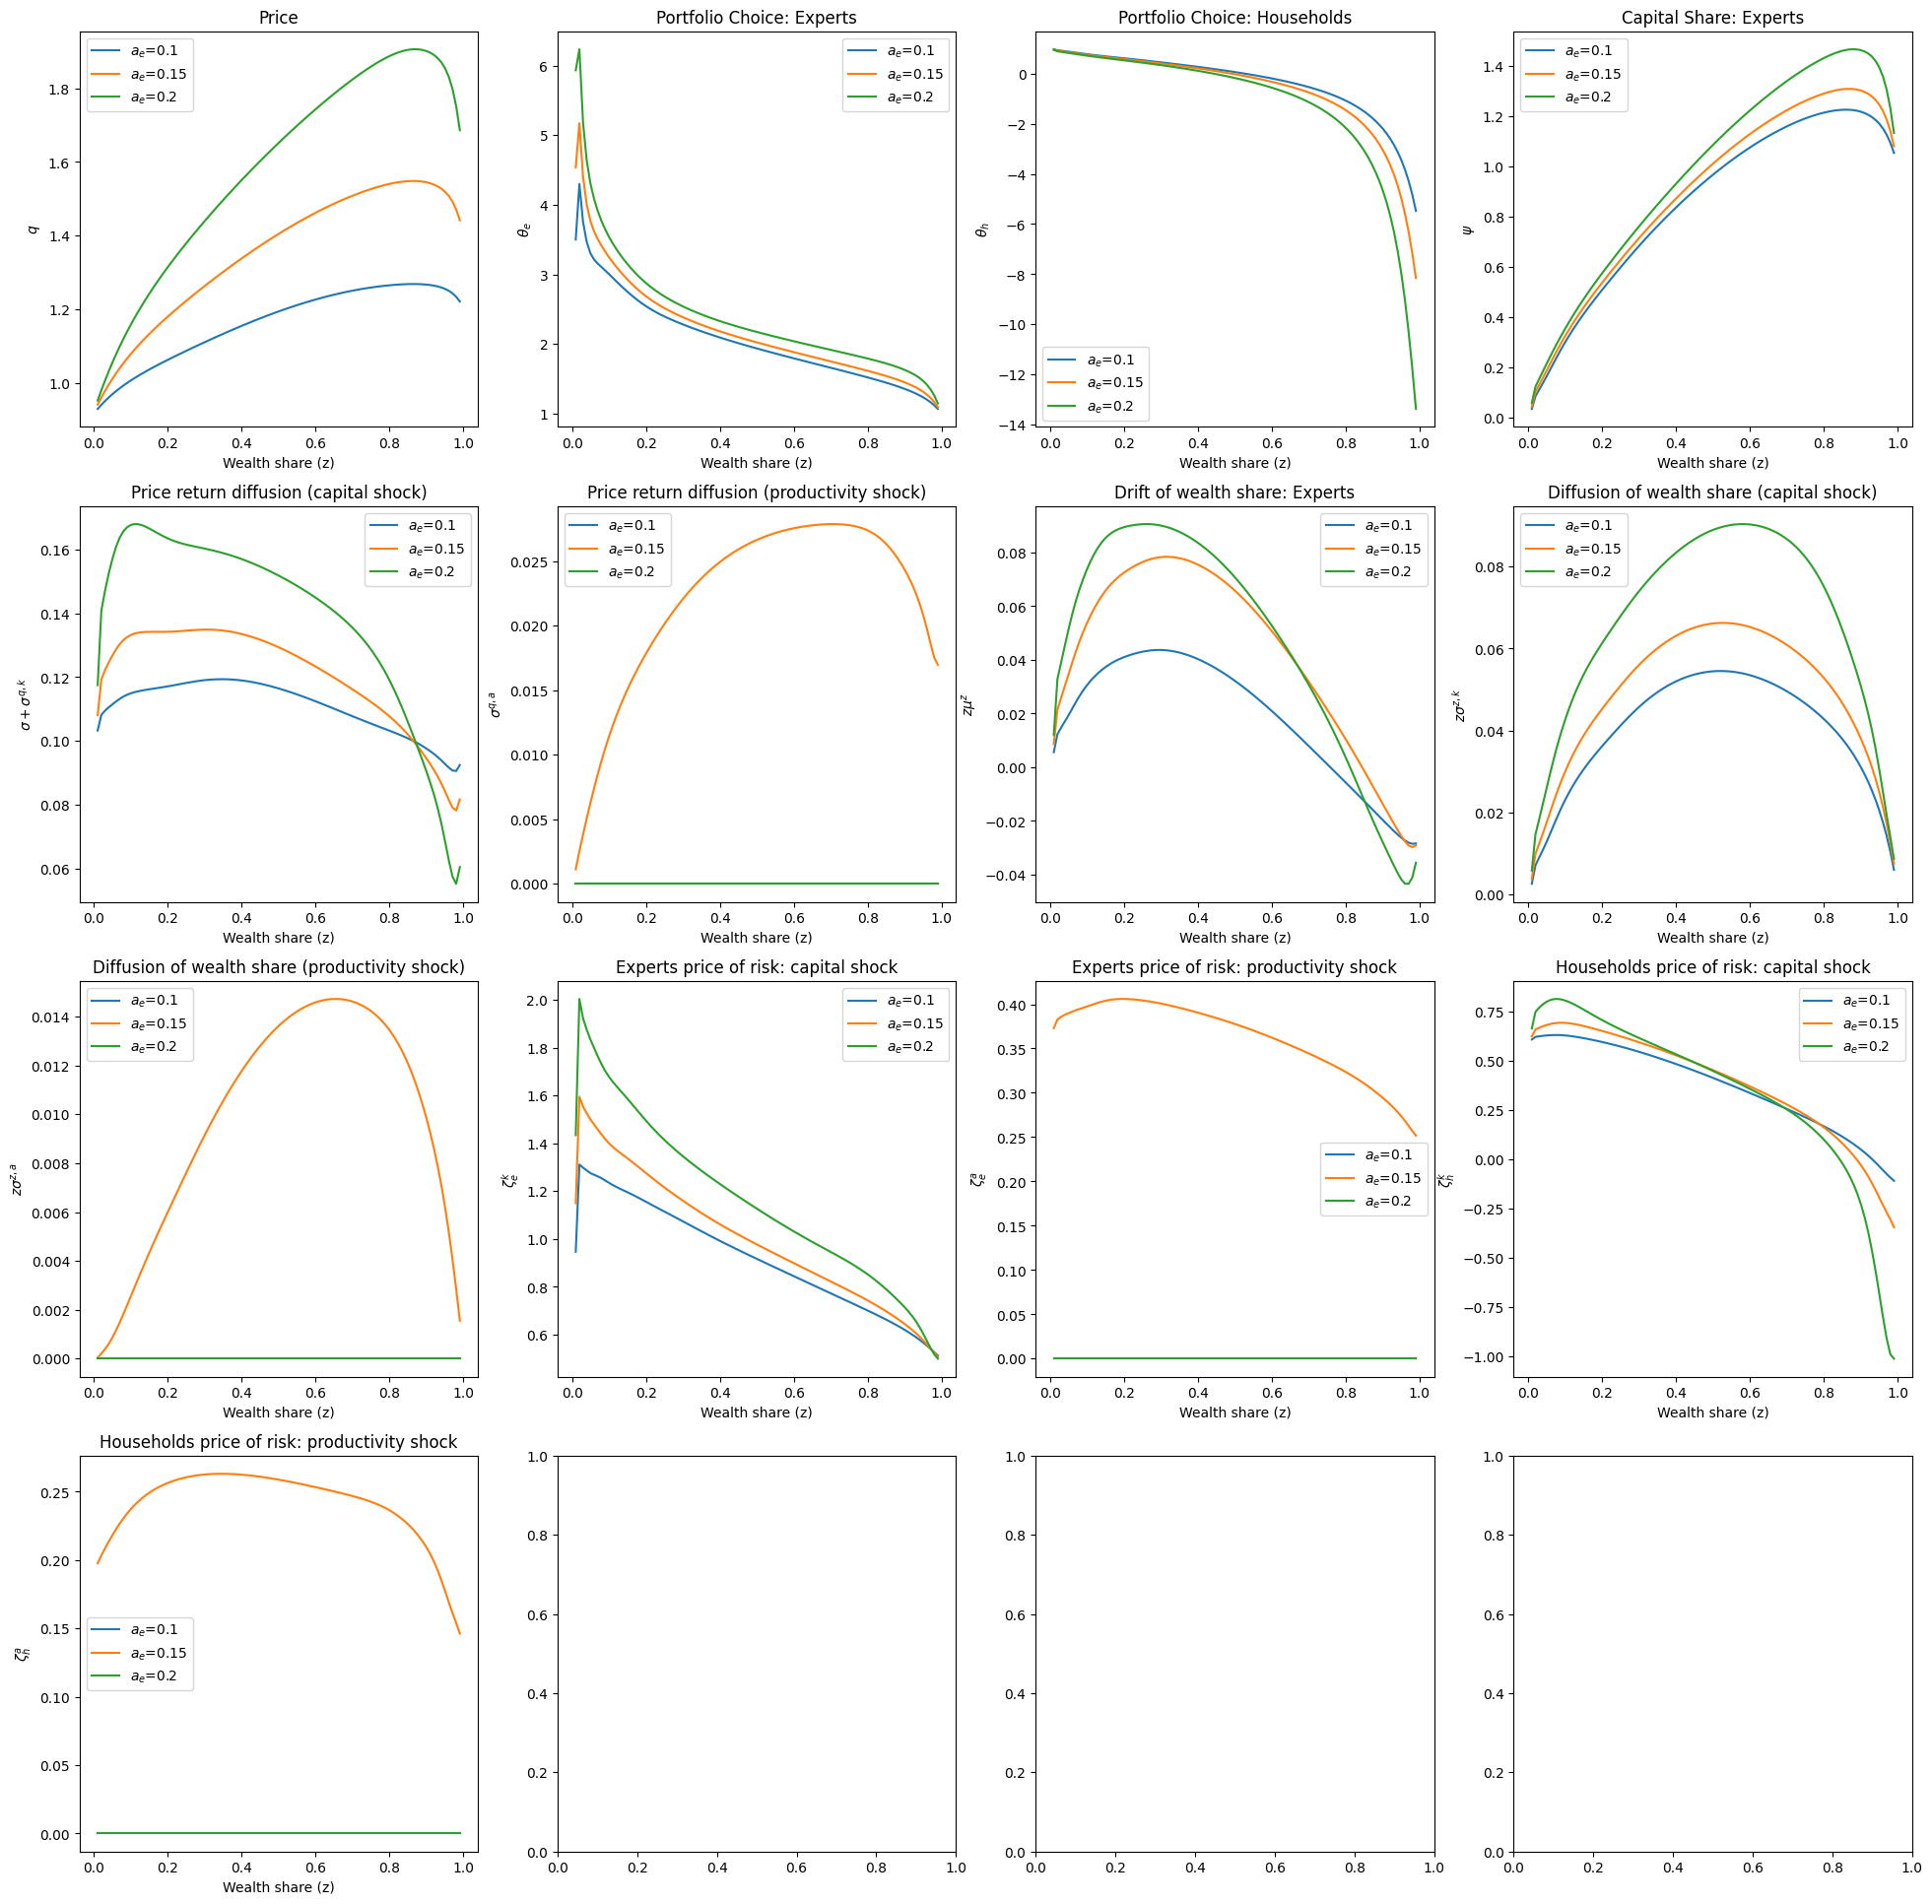

In [ ]:
set_seeds(0)
pde_model = PDEModelTimeStep("cd2d_ts",
                     {"batch_size": 500, "num_outer_iterations": 50, "num_inner_iterations": 5000,
                      "sampling_method": SamplingMethod.UniformRandom, "time_batch_size": 10},
                     latex_var_map)
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q", "psi"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "psi": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      })
pde_model.add_params(params)
zero_z = torch.zeros((100, 3), device=pde_model.device)
zero_z[:, 1] = torch.linspace(a_min, a_max, steps=100, device=pde_model.device)
one_z = torch.zeros((100, 3), device=pde_model.device)
one_z[:, 0] = torch.ones((100,), device=pde_model.device)
one_z[:, 1] = torch.linspace(a_min, a_max, steps=100, device=pde_model.device)
pde_model.add_endog_condition("q",
                              "q(SV)",
                              {"SV": zero_z},
                              Comparator.EQ,
                              "(1+kappa*ah)/(1+kappa*rho)", {"rho": params["rho"], "ah": params["ah"], "kappa": params["kappa"]},
                              label="q_min", weight=0.01)
pde_model.add_endog_condition("q",
                              "q(SV)",
                              {"SV": one_z},
                              Comparator.EQ,
                              "(1+kappa*ae)/(1+kappa*rho)", {"rho": params["rho"], "ae": zero_z[:, 1:2], "kappa": params["kappa"]},
                              label="q_max", weight=0.01)
pde_model.add_endog_condition("psi",
                              "psi(SV)",
                              {"SV": zero_z},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min", weight=0.01)
pde_model.add_endog_condition("psi",
                              "psi(SV)",
                              {"SV": one_z},
                              Comparator.EQ,
                              "1", {},
                              label="psi_max", weight=0.01)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\underline{\chi} * \psi}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \underline{\chi} * \psi}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} * \psi - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} * \psi - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\underline{\chi}) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2 * \phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - (\Phi - \delta) + (\gamma - 1) * ( \sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a}) - \rho * (\log(\rho) - \log(J_e) + \log(z*q))$")
pde_model.add_equation(r"$\mu_h^J &= \frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi*\sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - (\Phi-\delta) + (\gamma - 1) * (\sigma_h^{J,k}*\sigma + \phi*\sigma*\sigma_h^{J,a})- \rho * (\log(\rho) - \log(J_h) + \log((1-z)*q))$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \underline{\chi} * \epsilon_e - (1-\underline{\chi}) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= \psi * a_e + (1-\psi) * a_h - \iota$")
pde_model.add_endog_equation(r"$\frac{a_e - a_h}{q} &= \underline{\chi} * (\epsilon_e - \epsilon_h)$")

pde_model.add_hjb_equation(r"$\frac{\partial J_e}{\partial t} + \frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) +\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_e^J * J_e$")
pde_model.add_hjb_equation(r"$\frac{\partial J_h}{\partial t} + \frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) + \frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_h^J * J_h$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region1.pt"):
    pde_model.train_model(base_model_dir, "region1.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))
    pde_model.eval_model(True)

res_dict1 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict1, plot_args, a_list)
torch.cuda.empty_cache()

## Region 2
$\psi = 1$, but $\epsilon_e \geq \epsilon_h$

============================Summary of Model cd2d_ts============================
Config: {
 "batch_size": 500,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "UniformRandom",
 "time_batch_size": 10,
 "boundary_grid_size": null
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zeta_h^a

Total loss: 0.0012: 100%|██████████| 5000/5000 [14:15<00:00,  5.84it/s]


Model loaded
Je: Mean Value: 0.83076, Absolute Change: 0.16924, Relative Change:  0.16924
Jh: Mean Value: 0.82655, Absolute Change: 0.17345, Relative Change:  0.17345
q: Mean Value: 1.41354, Absolute Change: 0.41354, Relative Change:  0.41354
Updating min loss from inf to 0.0012
Outer Loop 0 Finished in 855.6221s. Loading best model...


Total loss: 0.0003: 100%|██████████| 3535/3535 [10:17<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.70136, Absolute Change: 0.12941, Relative Change:  0.15696
Jh: Mean Value: 0.69434, Absolute Change: 0.13222, Relative Change:  0.16138
q: Mean Value: 1.39628, Absolute Change: 0.01726, Relative Change:  0.01213
Updating min loss from 0.0012 to 0.0001
Outer Loop 1 Finished in 617.5271s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2886/2886 [08:23<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.59843, Absolute Change: 0.10293, Relative Change:  0.14859
Jh: Mean Value: 0.58925, Absolute Change: 0.10509, Relative Change:  0.15356
q: Mean Value: 1.39727, Absolute Change: 0.00370, Relative Change:  0.00263
Updating min loss from 0.0001 to 0.0000
Outer Loop 2 Finished in 503.8413s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2500/2500 [07:22<00:00,  5.65it/s]


Model loaded
Je: Mean Value: 0.51490, Absolute Change: 0.08353, Relative Change:  0.14182
Jh: Mean Value: 0.50444, Absolute Change: 0.08480, Relative Change:  0.14647
q: Mean Value: 1.39885, Absolute Change: 0.00309, Relative Change:  0.00220
Updating min loss from 0.0000 to 0.0000
Outer Loop 3 Finished in 442.5820s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2236/2236 [06:33<00:00,  5.68it/s]


Model loaded
Je: Mean Value: 0.44642, Absolute Change: 0.06848, Relative Change:  0.13549
Jh: Mean Value: 0.43517, Absolute Change: 0.06928, Relative Change:  0.14007
q: Mean Value: 1.39856, Absolute Change: 0.00365, Relative Change:  0.00266
Updating min loss from 0.0000 to 0.0000
Outer Loop 4 Finished in 393.8872s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2041/2041 [05:57<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.38980, Absolute Change: 0.05662, Relative Change:  0.12948
Jh: Mean Value: 0.37796, Absolute Change: 0.05721, Relative Change:  0.13418
q: Mean Value: 1.39693, Absolute Change: 0.00686, Relative Change:  0.00475
Outer Loop 5 Finished in 357.7446s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1889/1889 [05:29<00:00,  5.74it/s]


Model loaded
Je: Mean Value: 0.34264, Absolute Change: 0.04715, Relative Change:  0.12370
Jh: Mean Value: 0.33059, Absolute Change: 0.04737, Relative Change:  0.12821
q: Mean Value: 1.39913, Absolute Change: 0.00428, Relative Change:  0.00298
Updating min loss from 0.0000 to 0.0000
Outer Loop 6 Finished in 329.0086s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1767/1767 [05:09<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.30328, Absolute Change: 0.03936, Relative Change:  0.11761
Jh: Mean Value: 0.29091, Absolute Change: 0.03968, Relative Change:  0.12290
q: Mean Value: 1.39963, Absolute Change: 0.00422, Relative Change:  0.00303
Outer Loop 7 Finished in 309.1354s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1666/1666 [04:49<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.26972, Absolute Change: 0.03357, Relative Change:  0.11345
Jh: Mean Value: 0.25752, Absolute Change: 0.03338, Relative Change:  0.11753
q: Mean Value: 1.39776, Absolute Change: 0.00473, Relative Change:  0.00343
Outer Loop 8 Finished in 289.1977s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1581/1581 [04:33<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.24116, Absolute Change: 0.02855, Relative Change:  0.10846
Jh: Mean Value: 0.22922, Absolute Change: 0.02830, Relative Change:  0.11264
q: Mean Value: 1.39854, Absolute Change: 0.00235, Relative Change:  0.00171
Updating min loss from 0.0000 to 0.0000
Outer Loop 9 Finished in 273.9559s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1507/1507 [04:23<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.21673, Absolute Change: 0.02443, Relative Change:  0.10389
Jh: Mean Value: 0.20515, Absolute Change: 0.02407, Relative Change:  0.10762
q: Mean Value: 1.39829, Absolute Change: 0.00102, Relative Change:  0.00074
Outer Loop 10 Finished in 263.1108s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1443/1443 [04:11<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.19573, Absolute Change: 0.02100, Relative Change:  0.09947
Jh: Mean Value: 0.18453, Absolute Change: 0.02063, Relative Change:  0.10309
q: Mean Value: 1.39881, Absolute Change: 0.00124, Relative Change:  0.00088
Updating min loss from 0.0000 to 0.0000
Outer Loop 11 Finished in 251.8539s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1386/1386 [04:00<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.17757, Absolute Change: 0.01816, Relative Change:  0.09511
Jh: Mean Value: 0.16676, Absolute Change: 0.01777, Relative Change:  0.09873
q: Mean Value: 1.39941, Absolute Change: 0.00219, Relative Change:  0.00161
Outer Loop 12 Finished in 240.3379s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [03:50<00:00,  5.80it/s]


Model loaded
Je: Mean Value: 0.16163, Absolute Change: 0.01594, Relative Change:  0.09210
Jh: Mean Value: 0.15141, Absolute Change: 0.01534, Relative Change:  0.09433
q: Mean Value: 1.39823, Absolute Change: 0.00339, Relative Change:  0.00249
Outer Loop 13 Finished in 230.4542s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [03:46<00:00,  5.69it/s]


Model loaded
Je: Mean Value: 0.14794, Absolute Change: 0.01369, Relative Change:  0.08691
Jh: Mean Value: 0.13813, Absolute Change: 0.01328, Relative Change:  0.08999
q: Mean Value: 1.39977, Absolute Change: 0.00421, Relative Change:  0.00308
Updating min loss from 0.0000 to 0.0000
Outer Loop 14 Finished in 226.9085s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [03:36<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.13572, Absolute Change: 0.01222, Relative Change:  0.08495
Jh: Mean Value: 0.12650, Absolute Change: 0.01163, Relative Change:  0.08626
q: Mean Value: 1.39820, Absolute Change: 0.00346, Relative Change:  0.00254
Outer Loop 15 Finished in 216.9362s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [03:32<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.12496, Absolute Change: 0.01077, Relative Change:  0.08167
Jh: Mean Value: 0.11636, Absolute Change: 0.01014, Relative Change:  0.08231
q: Mean Value: 1.39873, Absolute Change: 0.00172, Relative Change:  0.00123
Outer Loop 16 Finished in 212.3178s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1178/1178 [03:25<00:00,  5.74it/s]


Model loaded
Je: Mean Value: 0.11550, Absolute Change: 0.00945, Relative Change:  0.07771
Jh: Mean Value: 0.10740, Absolute Change: 0.00896, Relative Change:  0.07905
q: Mean Value: 1.39917, Absolute Change: 0.00093, Relative Change:  0.00066
Updating min loss from 0.0000 to 0.0000
Outer Loop 17 Finished in 205.0866s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [03:19<00:00,  5.75it/s]


Model loaded
Je: Mean Value: 0.10719, Absolute Change: 0.00832, Relative Change:  0.07385
Jh: Mean Value: 0.09945, Absolute Change: 0.00795, Relative Change:  0.07588
q: Mean Value: 1.39940, Absolute Change: 0.00080, Relative Change:  0.00058
Updating min loss from 0.0000 to 0.0000
Outer Loop 18 Finished in 199.5316s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1118/1118 [03:13<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.09972, Absolute Change: 0.00746, Relative Change:  0.07161
Jh: Mean Value: 0.09240, Absolute Change: 0.00704, Relative Change:  0.07246
q: Mean Value: 1.39956, Absolute Change: 0.00091, Relative Change:  0.00064
Outer Loop 19 Finished in 193.8598s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1091/1091 [03:12<00:00,  5.68it/s]


Model loaded
Je: Mean Value: 0.09296, Absolute Change: 0.00676, Relative Change:  0.06985
Jh: Mean Value: 0.08618, Absolute Change: 0.00622, Relative Change:  0.06901
q: Mean Value: 1.39883, Absolute Change: 0.00113, Relative Change:  0.00081
Outer Loop 20 Finished in 192.1535s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1066/1066 [03:06<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.08694, Absolute Change: 0.00603, Relative Change:  0.06693
Jh: Mean Value: 0.08058, Absolute Change: 0.00560, Relative Change:  0.06647
q: Mean Value: 1.39836, Absolute Change: 0.00079, Relative Change:  0.00057
Outer Loop 21 Finished in 186.5544s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1042/1042 [03:02<00:00,  5.69it/s]


Model loaded
Je: Mean Value: 0.08154, Absolute Change: 0.00539, Relative Change:  0.06395
Jh: Mean Value: 0.07558, Absolute Change: 0.00500, Relative Change:  0.06337
q: Mean Value: 1.39907, Absolute Change: 0.00093, Relative Change:  0.00068
Updating min loss from 0.0000 to 0.0000
Outer Loop 22 Finished in 183.0016s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [02:59<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.07669, Absolute Change: 0.00486, Relative Change:  0.06149
Jh: Mean Value: 0.07108, Absolute Change: 0.00450, Relative Change:  0.06065
q: Mean Value: 1.39902, Absolute Change: 0.00112, Relative Change:  0.00078
Outer Loop 23 Finished in 179.0557s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


Model loaded
Je: Mean Value: 0.07234, Absolute Change: 0.00435, Relative Change:  0.05822
Jh: Mean Value: 0.06698, Absolute Change: 0.00410, Relative Change:  0.05882
q: Mean Value: 1.39889, Absolute Change: 0.00103, Relative Change:  0.00072
Updating min loss from 0.0000 to 0.0000
Outer Loop 24 Finished in 175.8812s. Loading best model...


Total loss: 0.0000: 100%|██████████| 980/980 [02:49<00:00,  5.79it/s]


Model loaded
Je: Mean Value: 0.06830, Absolute Change: 0.00404, Relative Change:  0.05775
Jh: Mean Value: 0.06334, Absolute Change: 0.00363, Relative Change:  0.05534
q: Mean Value: 1.39868, Absolute Change: 0.00054, Relative Change:  0.00040
Outer Loop 25 Finished in 169.3888s. Loading best model...


Total loss: 0.0000: 100%|██████████| 962/962 [02:47<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.06483, Absolute Change: 0.00347, Relative Change:  0.05166
Jh: Mean Value: 0.05995, Absolute Change: 0.00339, Relative Change:  0.05430
q: Mean Value: 1.40010, Absolute Change: 0.00167, Relative Change:  0.00123
Updating min loss from 0.0000 to 0.0000
Outer Loop 26 Finished in 167.8140s. Loading best model...


Total loss: 0.0000: 100%|██████████| 944/944 [02:43<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.06159, Absolute Change: 0.00324, Relative Change:  0.05212
Jh: Mean Value: 0.05675, Absolute Change: 0.00320, Relative Change:  0.05423
q: Mean Value: 1.39883, Absolute Change: 0.00244, Relative Change:  0.00176
Outer Loop 27 Finished in 163.5382s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [02:41<00:00,  5.75it/s]


Model loaded
Je: Mean Value: 0.05870, Absolute Change: 0.00289, Relative Change:  0.04815
Jh: Mean Value: 0.05367, Absolute Change: 0.00308, Relative Change:  0.05473
q: Mean Value: 1.39877, Absolute Change: 0.00175, Relative Change:  0.00124
Updating min loss from 0.0000 to 0.0000
Outer Loop 28 Finished in 161.3380s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [02:36<00:00,  5.83it/s]


Model loaded
Je: Mean Value: 0.05615, Absolute Change: 0.00255, Relative Change:  0.04376
Jh: Mean Value: 0.05081, Absolute Change: 0.00287, Relative Change:  0.05364
q: Mean Value: 1.39866, Absolute Change: 0.00145, Relative Change:  0.00105
Updating min loss from 0.0000 to 0.0000
Outer Loop 29 Finished in 156.5150s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [02:35<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.05391, Absolute Change: 0.00223, Relative Change:  0.03940
Jh: Mean Value: 0.04829, Absolute Change: 0.00251, Relative Change:  0.04958
q: Mean Value: 1.39862, Absolute Change: 0.00083, Relative Change:  0.00060
Updating min loss from 0.0000 to 0.0000
Outer Loop 30 Finished in 155.5285s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [02:33<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.05189, Absolute Change: 0.00203, Relative Change:  0.03687
Jh: Mean Value: 0.04604, Absolute Change: 0.00225, Relative Change:  0.04681
q: Mean Value: 1.39865, Absolute Change: 0.00060, Relative Change:  0.00044
Outer Loop 31 Finished in 153.2196s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [02:29<00:00,  5.82it/s]


Model loaded
Je: Mean Value: 0.05002, Absolute Change: 0.00187, Relative Change:  0.03538
Jh: Mean Value: 0.04400, Absolute Change: 0.00204, Relative Change:  0.04446
q: Mean Value: 1.39875, Absolute Change: 0.00049, Relative Change:  0.00035
Updating min loss from 0.0000 to 0.0000
Outer Loop 32 Finished in 149.4521s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [02:28<00:00,  5.78it/s]


Model loaded
Je: Mean Value: 0.04831, Absolute Change: 0.00171, Relative Change:  0.03339
Jh: Mean Value: 0.04215, Absolute Change: 0.00185, Relative Change:  0.04253
q: Mean Value: 1.39870, Absolute Change: 0.00043, Relative Change:  0.00031
Outer Loop 33 Finished in 148.2023s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [02:27<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.04674, Absolute Change: 0.00157, Relative Change:  0.03192
Jh: Mean Value: 0.04047, Absolute Change: 0.00168, Relative Change:  0.04018
q: Mean Value: 1.39864, Absolute Change: 0.00043, Relative Change:  0.00031
Outer Loop 34 Finished in 147.3570s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [02:25<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.04528, Absolute Change: 0.00146, Relative Change:  0.03085
Jh: Mean Value: 0.03895, Absolute Change: 0.00152, Relative Change:  0.03792
q: Mean Value: 1.39876, Absolute Change: 0.00031, Relative Change:  0.00023
Updating min loss from 0.0000 to 0.0000
Outer Loop 35 Finished in 145.6211s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [02:23<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.04391, Absolute Change: 0.00137, Relative Change:  0.02981
Jh: Mean Value: 0.03754, Absolute Change: 0.00141, Relative Change:  0.03649
q: Mean Value: 1.39854, Absolute Change: 0.00035, Relative Change:  0.00025
Outer Loop 36 Finished in 143.4829s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [02:20<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.04257, Absolute Change: 0.00134, Relative Change:  0.03062
Jh: Mean Value: 0.03684, Absolute Change: 0.00138, Relative Change:  0.03979
q: Mean Value: 1.39866, Absolute Change: 0.00217, Relative Change:  0.00155
Outer Loop 37 Finished in 140.5170s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [02:19<00:00,  5.75it/s]


Model loaded
Je: Mean Value: 0.04131, Absolute Change: 0.00126, Relative Change:  0.03061
Jh: Mean Value: 0.03563, Absolute Change: 0.00120, Relative Change:  0.03325
q: Mean Value: 1.39851, Absolute Change: 0.00189, Relative Change:  0.00134
Outer Loop 38 Finished in 139.0799s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [02:15<00:00,  5.85it/s]


Model loaded
Je: Mean Value: 0.04021, Absolute Change: 0.00110, Relative Change:  0.02644
Jh: Mean Value: 0.03450, Absolute Change: 0.00114, Relative Change:  0.03190
q: Mean Value: 1.39850, Absolute Change: 0.00064, Relative Change:  0.00045
Outer Loop 39 Finished in 135.1332s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [02:16<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.03921, Absolute Change: 0.00100, Relative Change:  0.02485
Jh: Mean Value: 0.03346, Absolute Change: 0.00103, Relative Change:  0.02999
q: Mean Value: 1.39847, Absolute Change: 0.00036, Relative Change:  0.00026
Outer Loop 40 Finished in 136.9301s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [02:10<00:00,  5.91it/s]


Model loaded
Je: Mean Value: 0.03828, Absolute Change: 0.00093, Relative Change:  0.02336
Jh: Mean Value: 0.03257, Absolute Change: 0.00089, Relative Change:  0.02671
q: Mean Value: 1.39864, Absolute Change: 0.00027, Relative Change:  0.00019
Updating min loss from 0.0000 to 0.0000
Outer Loop 41 Finished in 130.3558s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [02:10<00:00,  5.83it/s]


Model loaded
Je: Mean Value: 0.03742, Absolute Change: 0.00087, Relative Change:  0.02244
Jh: Mean Value: 0.03176, Absolute Change: 0.00081, Relative Change:  0.02471
q: Mean Value: 1.39851, Absolute Change: 0.00022, Relative Change:  0.00016
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 130.6462s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [02:11<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.03661, Absolute Change: 0.00081, Relative Change:  0.02147
Jh: Mean Value: 0.03100, Absolute Change: 0.00077, Relative Change:  0.02444
q: Mean Value: 1.39848, Absolute Change: 0.00018, Relative Change:  0.00013
Outer Loop 43 Finished in 131.9216s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [02:11<00:00,  5.69it/s]


Model loaded
Je: Mean Value: 0.03585, Absolute Change: 0.00076, Relative Change:  0.02065
Jh: Mean Value: 0.03026, Absolute Change: 0.00073, Relative Change:  0.02377
q: Mean Value: 1.39848, Absolute Change: 0.00018, Relative Change:  0.00013
Outer Loop 44 Finished in 131.0192s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [02:09<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.03514, Absolute Change: 0.00071, Relative Change:  0.01975
Jh: Mean Value: 0.02959, Absolute Change: 0.00067, Relative Change:  0.02236
q: Mean Value: 1.39854, Absolute Change: 0.00032, Relative Change:  0.00023
Updating min loss from 0.0000 to 0.0000
Outer Loop 45 Finished in 129.4098s. Loading best model...


Total loss: 0.0000: 100%|██████████| 729/729 [02:06<00:00,  5.74it/s]


Model loaded
Je: Mean Value: 0.03447, Absolute Change: 0.00067, Relative Change:  0.01900
Jh: Mean Value: 0.02896, Absolute Change: 0.00063, Relative Change:  0.02127
q: Mean Value: 1.39854, Absolute Change: 0.00019, Relative Change:  0.00013
Outer Loop 46 Finished in 126.9951s. Loading best model...


Total loss: 0.0000: 100%|██████████| 721/721 [02:05<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.03384, Absolute Change: 0.00062, Relative Change:  0.01810
Jh: Mean Value: 0.02838, Absolute Change: 0.00058, Relative Change:  0.02014
q: Mean Value: 1.39851, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 47 Finished in 125.1912s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [02:04<00:00,  5.75it/s]


Model loaded
Je: Mean Value: 0.03326, Absolute Change: 0.00059, Relative Change:  0.01724
Jh: Mean Value: 0.02783, Absolute Change: 0.00055, Relative Change:  0.01960
q: Mean Value: 1.39850, Absolute Change: 0.00017, Relative Change:  0.00012
Updating min loss from 0.0000 to 0.0000
Outer Loop 48 Finished in 124.2305s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [01:56<00:00,  6.08it/s]


Model loaded
Je: Mean Value: 0.03270, Absolute Change: 0.00055, Relative Change:  0.01677
Jh: Mean Value: 0.02749, Absolute Change: 0.00053, Relative Change:  0.01976
q: Mean Value: 1.39889, Absolute Change: 0.00109, Relative Change:  0.00079
Outer Loop 49 Finished in 116.2927s. Loading best model...
training finished, total time :: 11098.266330957413
Best model saved to ./models/cd_2d_timestep_random_sampling//region2_best.pt if valid
Model saved to ./models/cd_2d_timestep_random_sampling//region2.pt


<ipython-input-6-f4e5945bd56a>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))


Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
constraint_1: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_Je_cond_time_boundary: 0.0000,
agent_Jh_cond_time_boundary: 0.0000,
endogvar_q_cond_time_boundary: 0.0000,
total_loss: 0.0000


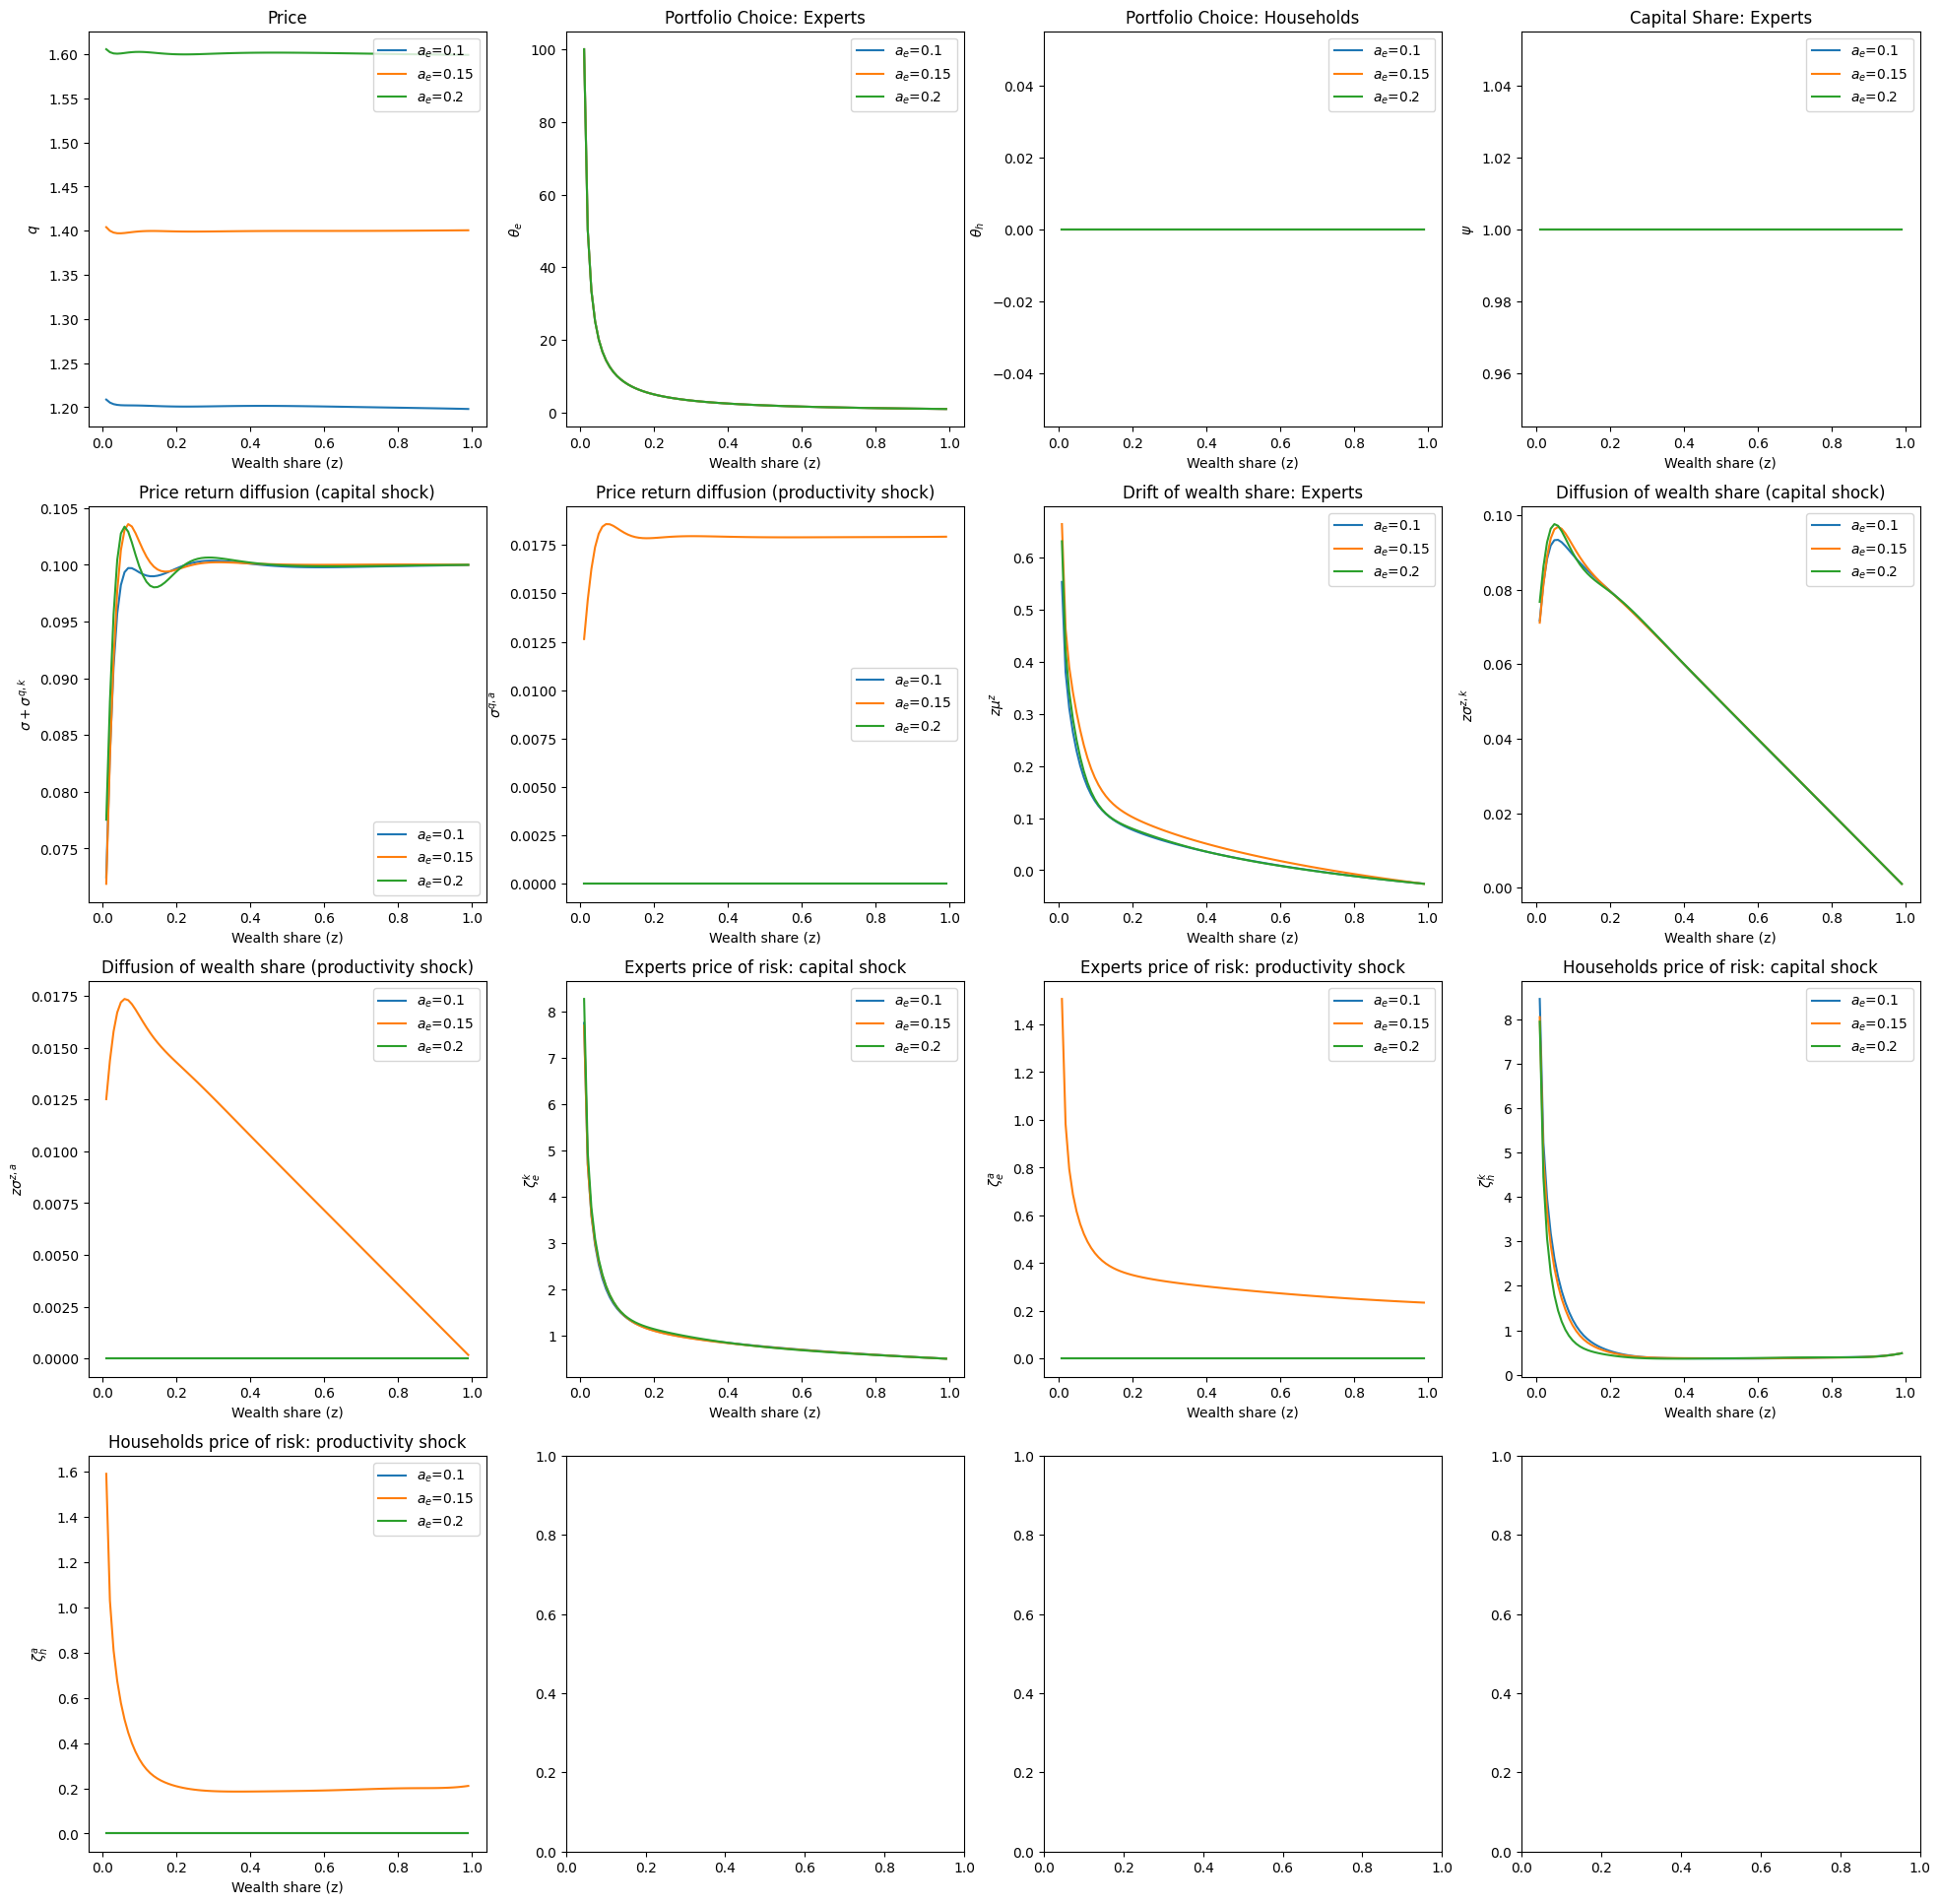

In [ ]:
set_seeds(0)
pde_model = PDEModelTimeStep("cd2d_ts",
                     {"batch_size": 500, "num_outer_iterations": 50, "num_inner_iterations": 5000,
                      "sampling_method": SamplingMethod.UniformRandom, "time_batch_size": 10},
                     latex_var_map)
torch.cuda.empty_cache()
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4}
                      })
pde_model.add_params(params)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\underline{\chi}}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \underline{\chi}}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\underline{\chi}) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2 * \phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - (\Phi - \delta) + (\gamma - 1) * ( \sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a}) - \rho * (\log(\rho) - \log(J_e) + \log(z*q))$")
pde_model.add_equation(r"$\mu_h^J &= \frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi*\sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - (\Phi-\delta) + (\gamma - 1) * (\sigma_h^{J,k}*\sigma + \phi*\sigma*\sigma_h^{J,a})- \rho * (\log(\rho) - \log(J_h) + \log((1-z)*q))$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \underline{\chi} * \epsilon_e - (1-\underline{\chi}) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= a_e - \iota$")
pde_model.add_constraint(r"$\frac{a_e - a_h}{q}$",
                         Comparator.GEQ,
                         r"$\underline{\chi} * (\epsilon_e - \epsilon_h)$")

pde_model.add_hjb_equation(r"$\frac{\partial J_e}{\partial t} + \frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) +\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_e^J * J_e$")
pde_model.add_hjb_equation(r"$\frac{\partial J_h}{\partial t} + \frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) + \frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_h^J * J_h$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region2.pt"):
    pde_model.train_model(base_model_dir, "region2.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))
    pde_model.eval_model(True)

res_dict2 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict2, plot_args, a_list)
torch.cuda.empty_cache()

## Region 3
$\psi = 1$, but $\epsilon_e = \epsilon_h$

============================Summary of Model cd2d_ts============================
Config: {
 "batch_size": 500,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "UniformRandom",
 "time_batch_size": 10,
 "boundary_grid_size": null
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zeta_h^a

Total loss: 0.0013: 100%|██████████| 5000/5000 [17:13<00:00,  4.84it/s]


Model loaded
Je: Mean Value: 0.82907, Absolute Change: 0.17093, Relative Change:  0.17093
Jh: Mean Value: 0.82726, Absolute Change: 0.17274, Relative Change:  0.17274
q: Mean Value: 1.41523, Absolute Change: 0.41523, Relative Change:  0.41523
chi: Mean Value: 0.65048, Absolute Change: 0.34965, Relative Change:  0.34965
Updating min loss from inf to 0.0013
Outer Loop 0 Finished in 1033.3808s. Loading best model...


Total loss: 0.0000: 100%|██████████| 3535/3535 [12:25<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.69689, Absolute Change: 0.13218, Relative Change:  0.16107
Jh: Mean Value: 0.69680, Absolute Change: 0.13046, Relative Change:  0.15919
q: Mean Value: 1.40211, Absolute Change: 0.01317, Relative Change:  0.00914
chi: Mean Value: 0.62430, Absolute Change: 0.02618, Relative Change:  0.05943
Updating min loss from 0.0013 to 0.0000
Outer Loop 1 Finished in 745.7576s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2886/2886 [10:00<00:00,  4.81it/s]


Model loaded
Je: Mean Value: 0.59082, Absolute Change: 0.10607, Relative Change:  0.15520
Jh: Mean Value: 0.59346, Absolute Change: 0.10334, Relative Change:  0.15069
q: Mean Value: 1.39702, Absolute Change: 0.00553, Relative Change:  0.00404
chi: Mean Value: 0.61477, Absolute Change: 0.01999, Relative Change:  0.05596
Updating min loss from 0.0000 to 0.0000
Outer Loop 2 Finished in 600.2581s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2500/2500 [08:43<00:00,  4.78it/s]


Model loaded
Je: Mean Value: 0.50493, Absolute Change: 0.08589, Relative Change:  0.14940
Jh: Mean Value: 0.51066, Absolute Change: 0.08280, Relative Change:  0.14241
q: Mean Value: 1.39883, Absolute Change: 0.00380, Relative Change:  0.00272
chi: Mean Value: 0.60947, Absolute Change: 0.00620, Relative Change:  0.01869
Updating min loss from 0.0000 to 0.0000
Outer Loop 3 Finished in 523.3095s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2236/2236 [07:52<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.43484, Absolute Change: 0.07009, Relative Change:  0.14359
Jh: Mean Value: 0.44323, Absolute Change: 0.06743, Relative Change:  0.13532
q: Mean Value: 1.39904, Absolute Change: 0.00469, Relative Change:  0.00328
chi: Mean Value: 0.60186, Absolute Change: 0.00775, Relative Change:  0.01647
Updating min loss from 0.0000 to 0.0000
Outer Loop 4 Finished in 472.4144s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2041/2041 [07:05<00:00,  4.79it/s]


Model loaded
Je: Mean Value: 0.37701, Absolute Change: 0.05783, Relative Change:  0.13848
Jh: Mean Value: 0.38787, Absolute Change: 0.05536, Relative Change:  0.12839
q: Mean Value: 1.39887, Absolute Change: 0.00083, Relative Change:  0.00061
chi: Mean Value: 0.59606, Absolute Change: 0.00581, Relative Change:  0.01358
Updating min loss from 0.0000 to 0.0000
Outer Loop 5 Finished in 425.6668s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1889/1889 [06:39<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.32904, Absolute Change: 0.04796, Relative Change:  0.13304
Jh: Mean Value: 0.34191, Absolute Change: 0.04596, Relative Change:  0.12215
q: Mean Value: 1.39877, Absolute Change: 0.00064, Relative Change:  0.00046
chi: Mean Value: 0.59149, Absolute Change: 0.00462, Relative Change:  0.01053
Updating min loss from 0.0000 to 0.0000
Outer Loop 6 Finished in 399.2021s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1767/1767 [06:13<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.28886, Absolute Change: 0.04019, Relative Change:  0.12836
Jh: Mean Value: 0.30369, Absolute Change: 0.03822, Relative Change:  0.11552
q: Mean Value: 1.39898, Absolute Change: 0.00037, Relative Change:  0.00027
chi: Mean Value: 0.58779, Absolute Change: 0.00374, Relative Change:  0.00881
Outer Loop 7 Finished in 373.3618s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1666/1666 [05:52<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.25513, Absolute Change: 0.03372, Relative Change:  0.12306
Jh: Mean Value: 0.27122, Absolute Change: 0.03248, Relative Change:  0.11074
q: Mean Value: 1.39903, Absolute Change: 0.00026, Relative Change:  0.00019
chi: Mean Value: 0.58477, Absolute Change: 0.00302, Relative Change:  0.00755
Updating min loss from 0.0000 to 0.0000
Outer Loop 8 Finished in 352.7043s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1581/1581 [05:36<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.22657, Absolute Change: 0.02857, Relative Change:  0.11843
Jh: Mean Value: 0.24365, Absolute Change: 0.02757, Relative Change:  0.10544
q: Mean Value: 1.39894, Absolute Change: 0.00022, Relative Change:  0.00016
chi: Mean Value: 0.58231, Absolute Change: 0.00253, Relative Change:  0.00587
Updating min loss from 0.0000 to 0.0000
Outer Loop 9 Finished in 336.1062s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1507/1507 [05:21<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.20223, Absolute Change: 0.02433, Relative Change:  0.11384
Jh: Mean Value: 0.22009, Absolute Change: 0.02356, Relative Change:  0.10046
q: Mean Value: 1.39892, Absolute Change: 0.00016, Relative Change:  0.00012
chi: Mean Value: 0.58041, Absolute Change: 0.00191, Relative Change:  0.00463
Updating min loss from 0.0000 to 0.0000
Outer Loop 10 Finished in 321.3933s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1443/1443 [05:06<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.18142, Absolute Change: 0.02081, Relative Change:  0.10922
Jh: Mean Value: 0.19982, Absolute Change: 0.02027, Relative Change:  0.09575
q: Mean Value: 1.39892, Absolute Change: 0.00015, Relative Change:  0.00011
chi: Mean Value: 0.57855, Absolute Change: 0.00188, Relative Change:  0.00453
Updating min loss from 0.0000 to 0.0000
Outer Loop 11 Finished in 306.5338s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1386/1386 [04:55<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.16349, Absolute Change: 0.01793, Relative Change:  0.10516
Jh: Mean Value: 0.18242, Absolute Change: 0.01740, Relative Change:  0.09060
q: Mean Value: 1.39890, Absolute Change: 0.00010, Relative Change:  0.00007
chi: Mean Value: 0.57718, Absolute Change: 0.00142, Relative Change:  0.00431
Outer Loop 12 Finished in 295.1765s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [04:43<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.14798, Absolute Change: 0.01551, Relative Change:  0.10111
Jh: Mean Value: 0.16717, Absolute Change: 0.01525, Relative Change:  0.08703
q: Mean Value: 1.39884, Absolute Change: 0.00018, Relative Change:  0.00013
chi: Mean Value: 0.57575, Absolute Change: 0.00145, Relative Change:  0.00322
Outer Loop 13 Finished in 283.0283s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [04:36<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.13453, Absolute Change: 0.01346, Relative Change:  0.09685
Jh: Mean Value: 0.15390, Absolute Change: 0.01327, Relative Change:  0.08264
q: Mean Value: 1.39883, Absolute Change: 0.00020, Relative Change:  0.00014
chi: Mean Value: 0.57436, Absolute Change: 0.00139, Relative Change:  0.00388
Updating min loss from 0.0000 to 0.0000
Outer Loop 14 Finished in 276.5424s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [04:30<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.12279, Absolute Change: 0.01174, Relative Change:  0.09319
Jh: Mean Value: 0.14222, Absolute Change: 0.01168, Relative Change:  0.07893
q: Mean Value: 1.39884, Absolute Change: 0.00012, Relative Change:  0.00009
chi: Mean Value: 0.57333, Absolute Change: 0.00115, Relative Change:  0.00251
Outer Loop 15 Finished in 270.2607s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [04:22<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.11253, Absolute Change: 0.01026, Relative Change:  0.08917
Jh: Mean Value: 0.13194, Absolute Change: 0.01028, Relative Change:  0.07523
q: Mean Value: 1.39889, Absolute Change: 0.00018, Relative Change:  0.00013
chi: Mean Value: 0.57240, Absolute Change: 0.00093, Relative Change:  0.00264
Outer Loop 16 Finished in 262.2018s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1178/1178 [04:13<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.10352, Absolute Change: 0.00901, Relative Change:  0.08549
Jh: Mean Value: 0.12283, Absolute Change: 0.00911, Relative Change:  0.07189
q: Mean Value: 1.39885, Absolute Change: 0.00016, Relative Change:  0.00012
chi: Mean Value: 0.57168, Absolute Change: 0.00076, Relative Change:  0.00245
Updating min loss from 0.0000 to 0.0000
Outer Loop 17 Finished in 253.3172s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [04:08<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.09553, Absolute Change: 0.00799, Relative Change:  0.08241
Jh: Mean Value: 0.11475, Absolute Change: 0.00808, Relative Change:  0.06850
q: Mean Value: 1.39873, Absolute Change: 0.00015, Relative Change:  0.00011
chi: Mean Value: 0.57099, Absolute Change: 0.00074, Relative Change:  0.00228
Updating min loss from 0.0000 to 0.0000
Outer Loop 18 Finished in 248.6490s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1118/1118 [04:01<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.08847, Absolute Change: 0.00706, Relative Change:  0.07892
Jh: Mean Value: 0.10755, Absolute Change: 0.00720, Relative Change:  0.06520
q: Mean Value: 1.39882, Absolute Change: 0.00015, Relative Change:  0.00010
chi: Mean Value: 0.57024, Absolute Change: 0.00083, Relative Change:  0.00228
Updating min loss from 0.0000 to 0.0000
Outer Loop 19 Finished in 241.9381s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1091/1091 [03:57<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.08220, Absolute Change: 0.00627, Relative Change:  0.07546
Jh: Mean Value: 0.10111, Absolute Change: 0.00644, Relative Change:  0.06223
q: Mean Value: 1.39888, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56965, Absolute Change: 0.00067, Relative Change:  0.00187
Outer Loop 20 Finished in 237.2120s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1066/1066 [03:52<00:00,  4.59it/s]


Model loaded
Je: Mean Value: 0.07660, Absolute Change: 0.00560, Relative Change:  0.07265
Jh: Mean Value: 0.09534, Absolute Change: 0.00577, Relative Change:  0.05918
q: Mean Value: 1.39877, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.56903, Absolute Change: 0.00071, Relative Change:  0.00236
Outer Loop 21 Finished in 232.2961s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1042/1042 [03:46<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.07159, Absolute Change: 0.00501, Relative Change:  0.07012
Jh: Mean Value: 0.09015, Absolute Change: 0.00520, Relative Change:  0.05665
q: Mean Value: 1.39881, Absolute Change: 0.00012, Relative Change:  0.00009
chi: Mean Value: 0.56862, Absolute Change: 0.00043, Relative Change:  0.00131
Outer Loop 22 Finished in 226.6519s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [03:41<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.06711, Absolute Change: 0.00449, Relative Change:  0.06683
Jh: Mean Value: 0.08546, Absolute Change: 0.00468, Relative Change:  0.05391
q: Mean Value: 1.39880, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56821, Absolute Change: 0.00042, Relative Change:  0.00149
Outer Loop 23 Finished in 221.7933s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [03:37<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.06308, Absolute Change: 0.00403, Relative Change:  0.06390
Jh: Mean Value: 0.08123, Absolute Change: 0.00423, Relative Change:  0.05130
q: Mean Value: 1.39877, Absolute Change: 0.00009, Relative Change:  0.00006
chi: Mean Value: 0.56769, Absolute Change: 0.00056, Relative Change:  0.00170
Outer Loop 24 Finished in 217.0671s. Loading best model...


Total loss: 0.0000: 100%|██████████| 980/980 [03:31<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.05945, Absolute Change: 0.00363, Relative Change:  0.06138
Jh: Mean Value: 0.07739, Absolute Change: 0.00384, Relative Change:  0.04892
q: Mean Value: 1.39885, Absolute Change: 0.00013, Relative Change:  0.00009
chi: Mean Value: 0.56735, Absolute Change: 0.00034, Relative Change:  0.00176
Outer Loop 25 Finished in 211.7879s. Loading best model...


Total loss: 0.0000: 100%|██████████| 962/962 [03:28<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.05617, Absolute Change: 0.00328, Relative Change:  0.05898
Jh: Mean Value: 0.07391, Absolute Change: 0.00349, Relative Change:  0.04652
q: Mean Value: 1.39879, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.56698, Absolute Change: 0.00048, Relative Change:  0.00157
Updating min loss from 0.0000 to 0.0000
Outer Loop 26 Finished in 208.2527s. Loading best model...


Total loss: 0.0000: 100%|██████████| 944/944 [03:24<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.05320, Absolute Change: 0.00296, Relative Change:  0.05547
Jh: Mean Value: 0.07073, Absolute Change: 0.00318, Relative Change:  0.04455
q: Mean Value: 1.39875, Absolute Change: 0.00010, Relative Change:  0.00007
chi: Mean Value: 0.56680, Absolute Change: 0.00030, Relative Change:  0.00134
Outer Loop 27 Finished in 204.5056s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [03:22<00:00,  4.59it/s]


Model loaded
Je: Mean Value: 0.05051, Absolute Change: 0.00269, Relative Change:  0.05347
Jh: Mean Value: 0.06782, Absolute Change: 0.00291, Relative Change:  0.04254
q: Mean Value: 1.39874, Absolute Change: 0.00009, Relative Change:  0.00007
chi: Mean Value: 0.56651, Absolute Change: 0.00034, Relative Change:  0.00118
Outer Loop 28 Finished in 202.0282s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [03:17<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.04806, Absolute Change: 0.00245, Relative Change:  0.05166
Jh: Mean Value: 0.06516, Absolute Change: 0.00266, Relative Change:  0.04052
q: Mean Value: 1.39876, Absolute Change: 0.00005, Relative Change:  0.00003
chi: Mean Value: 0.56628, Absolute Change: 0.00027, Relative Change:  0.00137
Outer Loop 29 Finished in 197.6284s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [03:14<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.04583, Absolute Change: 0.00224, Relative Change:  0.04950
Jh: Mean Value: 0.06273, Absolute Change: 0.00243, Relative Change:  0.03841
q: Mean Value: 1.39870, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56608, Absolute Change: 0.00037, Relative Change:  0.00218
Updating min loss from 0.0000 to 0.0000
Outer Loop 30 Finished in 194.8032s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [03:11<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.04379, Absolute Change: 0.00203, Relative Change:  0.04666
Jh: Mean Value: 0.06050, Absolute Change: 0.00223, Relative Change:  0.03651
q: Mean Value: 1.39873, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56577, Absolute Change: 0.00040, Relative Change:  0.00216
Outer Loop 31 Finished in 191.5918s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [03:06<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.04193, Absolute Change: 0.00187, Relative Change:  0.04515
Jh: Mean Value: 0.05845, Absolute Change: 0.00205, Relative Change:  0.03495
q: Mean Value: 1.39877, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.56571, Absolute Change: 0.00014, Relative Change:  0.00098
Updating min loss from 0.0000 to 0.0000
Outer Loop 32 Finished in 186.4108s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [03:03<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.04022, Absolute Change: 0.00171, Relative Change:  0.04271
Jh: Mean Value: 0.05656, Absolute Change: 0.00189, Relative Change:  0.03319
q: Mean Value: 1.39870, Absolute Change: 0.00009, Relative Change:  0.00006
chi: Mean Value: 0.56554, Absolute Change: 0.00028, Relative Change:  0.00154
Outer Loop 33 Finished in 183.9339s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [03:00<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.03866, Absolute Change: 0.00156, Relative Change:  0.04079
Jh: Mean Value: 0.05481, Absolute Change: 0.00175, Relative Change:  0.03171
q: Mean Value: 1.39875, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56535, Absolute Change: 0.00033, Relative Change:  0.00130
Outer Loop 34 Finished in 180.9210s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [02:57<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03722, Absolute Change: 0.00144, Relative Change:  0.03924
Jh: Mean Value: 0.05320, Absolute Change: 0.00161, Relative Change:  0.03021
q: Mean Value: 1.39877, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56528, Absolute Change: 0.00031, Relative Change:  0.00181
Outer Loop 35 Finished in 177.8810s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [02:56<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.03589, Absolute Change: 0.00133, Relative Change:  0.03738
Jh: Mean Value: 0.05172, Absolute Change: 0.00148, Relative Change:  0.02852
q: Mean Value: 1.39875, Absolute Change: 0.00005, Relative Change:  0.00004
chi: Mean Value: 0.56519, Absolute Change: 0.00022, Relative Change:  0.00099
Outer Loop 36 Finished in 176.0509s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [02:53<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.03467, Absolute Change: 0.00122, Relative Change:  0.03539
Jh: Mean Value: 0.05035, Absolute Change: 0.00137, Relative Change:  0.02714
q: Mean Value: 1.39872, Absolute Change: 0.00005, Relative Change:  0.00003
chi: Mean Value: 0.56517, Absolute Change: 0.00032, Relative Change:  0.00167
Outer Loop 37 Finished in 173.4929s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [02:50<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.03354, Absolute Change: 0.00113, Relative Change:  0.03452
Jh: Mean Value: 0.04907, Absolute Change: 0.00128, Relative Change:  0.02592
q: Mean Value: 1.39868, Absolute Change: 0.00009, Relative Change:  0.00007
chi: Mean Value: 0.56508, Absolute Change: 0.00019, Relative Change:  0.00095
Outer Loop 38 Finished in 170.5010s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [02:47<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.03249, Absolute Change: 0.00104, Relative Change:  0.03221
Jh: Mean Value: 0.04788, Absolute Change: 0.00119, Relative Change:  0.02472
q: Mean Value: 1.39875, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.56513, Absolute Change: 0.00015, Relative Change:  0.00075
Outer Loop 39 Finished in 167.3244s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [02:46<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03153, Absolute Change: 0.00096, Relative Change:  0.03110
Jh: Mean Value: 0.04677, Absolute Change: 0.00111, Relative Change:  0.02373
q: Mean Value: 1.39872, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.56515, Absolute Change: 0.00014, Relative Change:  0.00072
Outer Loop 40 Finished in 166.7091s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [02:40<00:00,  4.80it/s]


Model loaded
Je: Mean Value: 0.03063, Absolute Change: 0.00090, Relative Change:  0.02953
Jh: Mean Value: 0.04575, Absolute Change: 0.00102, Relative Change:  0.02232
q: Mean Value: 1.39873, Absolute Change: 0.00003, Relative Change:  0.00002
chi: Mean Value: 0.56506, Absolute Change: 0.00021, Relative Change:  0.00104
Updating min loss from 0.0000 to 0.0000
Outer Loop 41 Finished in 160.5888s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [02:43<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.02980, Absolute Change: 0.00083, Relative Change:  0.02807
Jh: Mean Value: 0.04479, Absolute Change: 0.00095, Relative Change:  0.02122
q: Mean Value: 1.39881, Absolute Change: 0.00010, Relative Change:  0.00007
chi: Mean Value: 0.56503, Absolute Change: 0.00015, Relative Change:  0.00065
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 163.4305s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [02:43<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.02903, Absolute Change: 0.00077, Relative Change:  0.02679
Jh: Mean Value: 0.04390, Absolute Change: 0.00090, Relative Change:  0.02057
q: Mean Value: 1.39873, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.56490, Absolute Change: 0.00019, Relative Change:  0.00138
Outer Loop 43 Finished in 163.8780s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [02:41<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.02832, Absolute Change: 0.00072, Relative Change:  0.02537
Jh: Mean Value: 0.04307, Absolute Change: 0.00083, Relative Change:  0.01922
q: Mean Value: 1.39873, Absolute Change: 0.00005, Relative Change:  0.00004
chi: Mean Value: 0.56482, Absolute Change: 0.00014, Relative Change:  0.00059
Outer Loop 44 Finished in 161.6519s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [02:39<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.02765, Absolute Change: 0.00067, Relative Change:  0.02439
Jh: Mean Value: 0.04229, Absolute Change: 0.00078, Relative Change:  0.01849
q: Mean Value: 1.39871, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.56490, Absolute Change: 0.00020, Relative Change:  0.00090
Outer Loop 45 Finished in 159.6866s. Loading best model...


Total loss: 0.0000: 100%|██████████| 729/729 [02:38<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.02704, Absolute Change: 0.00062, Relative Change:  0.02268
Jh: Mean Value: 0.04156, Absolute Change: 0.00073, Relative Change:  0.01773
q: Mean Value: 1.39869, Absolute Change: 0.00006, Relative Change:  0.00004
chi: Mean Value: 0.56492, Absolute Change: 0.00022, Relative Change:  0.00063
Outer Loop 46 Finished in 158.0350s. Loading best model...


Total loss: 0.0000: 100%|██████████| 721/721 [02:36<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.02645, Absolute Change: 0.00058, Relative Change:  0.02228
Jh: Mean Value: 0.04088, Absolute Change: 0.00067, Relative Change:  0.01625
q: Mean Value: 1.39869, Absolute Change: 0.00006, Relative Change:  0.00004
chi: Mean Value: 0.56484, Absolute Change: 0.00018, Relative Change:  0.00083
Outer Loop 47 Finished in 156.0646s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [02:34<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.02591, Absolute Change: 0.00054, Relative Change:  0.02063
Jh: Mean Value: 0.04025, Absolute Change: 0.00063, Relative Change:  0.01570
q: Mean Value: 1.39877, Absolute Change: 0.00010, Relative Change:  0.00007
chi: Mean Value: 0.56487, Absolute Change: 0.00015, Relative Change:  0.00062
Outer Loop 48 Finished in 154.4111s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [02:33<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.02541, Absolute Change: 0.00050, Relative Change:  0.01944
Jh: Mean Value: 0.03966, Absolute Change: 0.00060, Relative Change:  0.01502
q: Mean Value: 1.39857, Absolute Change: 0.00020, Relative Change:  0.00015
chi: Mean Value: 0.56490, Absolute Change: 0.00012, Relative Change:  0.00066
Outer Loop 49 Finished in 153.3766s. Loading best model...
training finished, total time :: 13592.692873954773
Best model saved to ./models/cd_2d_timestep_random_sampling//region3_best.pt if valid
Model saved to ./models/cd_2d_timestep_random_sampling//region3.pt


<ipython-input-7-c7faae73d0de>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))


Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_Je_cond_time_boundary: 0.0000,
agent_Jh_cond_time_boundary: 0.0000,
endogvar_q_cond_time_boundary: 0.0000,
endogvar_chi_cond_time_boundary: 0.0000,
total_loss: 0.0001


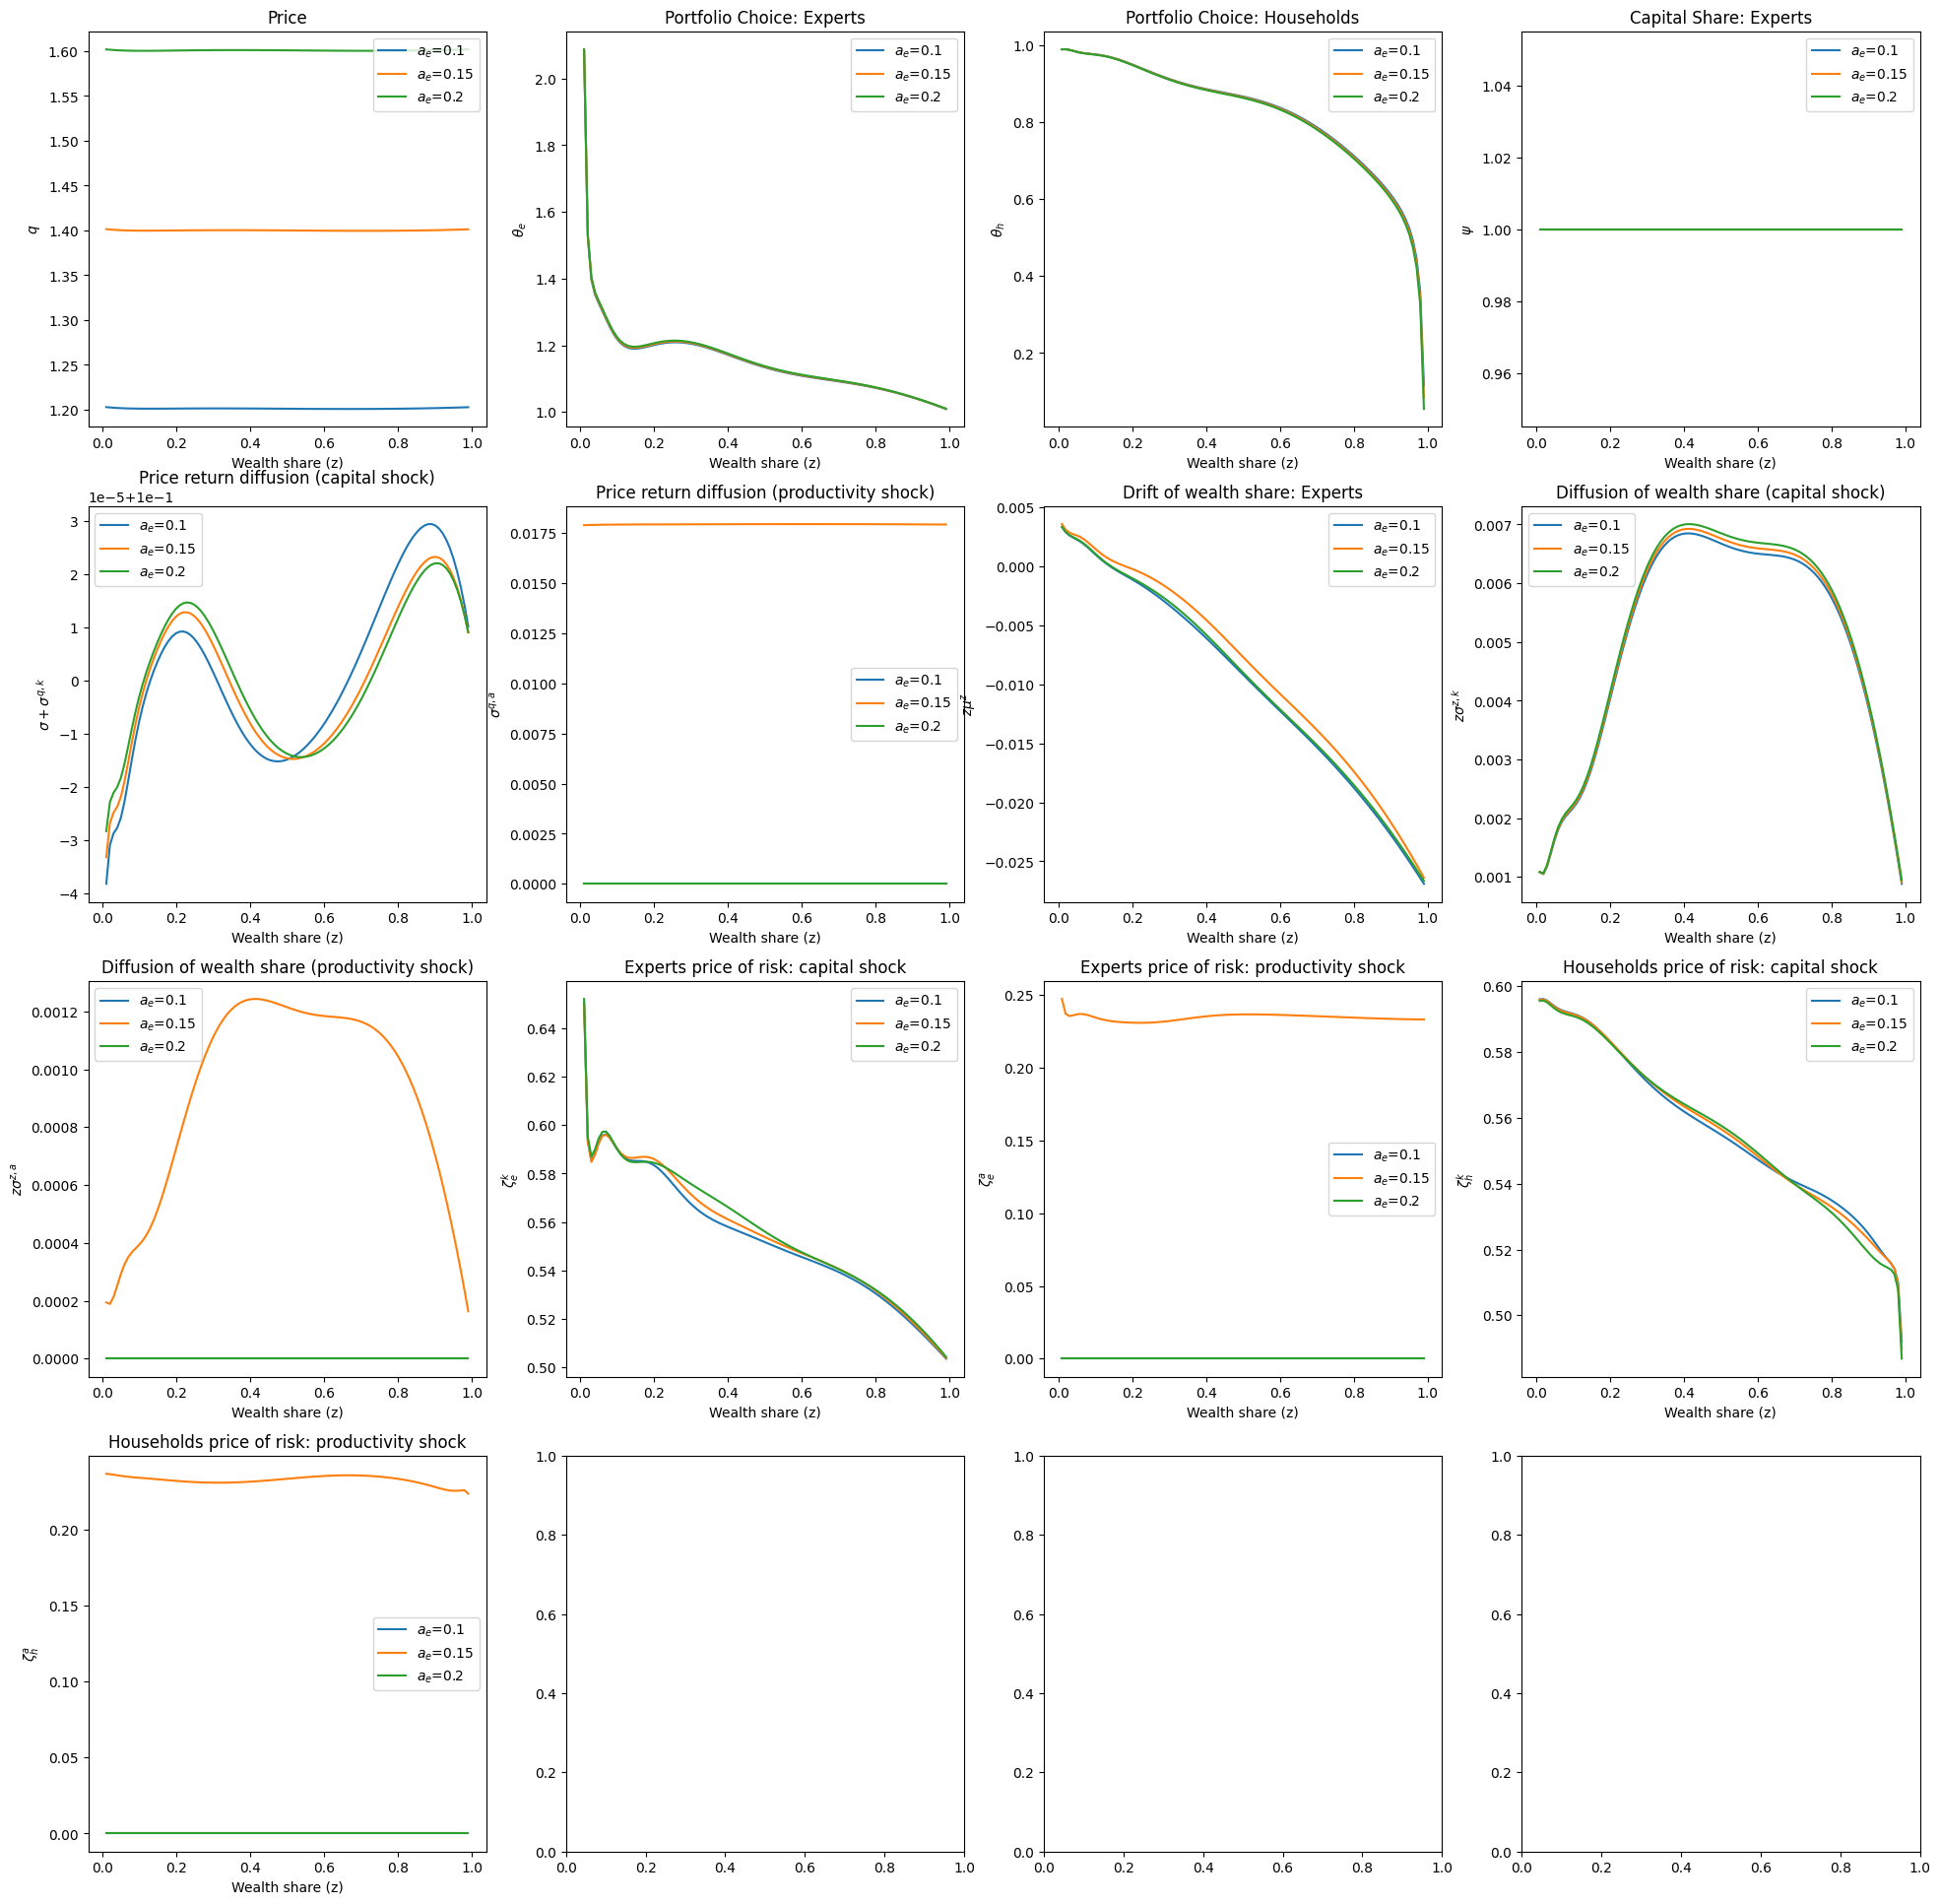

In [7]:
set_seeds(0)
pde_model = PDEModelTimeStep("cd2d_ts",
                     {"batch_size": 500, "num_outer_iterations": 50, "num_inner_iterations": 5000,
                      "sampling_method": SamplingMethod.UniformRandom, "time_batch_size": 10},
                     latex_var_map)
torch.cuda.empty_cache()
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q", "chi"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "chi": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4}
                      })
pde_model.add_params(params)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\chi}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \chi}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\chi - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\chi - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\chi) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2 * \phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - (\Phi - \delta) + (\gamma - 1) * ( \sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a}) - \rho * (\log(\rho) - \log(J_e) + \log(z*q))$")
pde_model.add_equation(r"$\mu_h^J &= \frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi*\sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - (\Phi-\delta) + (\gamma - 1) * (\sigma_h^{J,k}*\sigma + \phi*\sigma*\sigma_h^{J,a})- \rho * (\log(\rho) - \log(J_h) + \log((1-z)*q))$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \chi * \epsilon_e - (1-\chi) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= a_e - \iota$")
pde_model.add_endog_equation(r"$\epsilon_e &= \epsilon_h$")

pde_model.add_hjb_equation(r"$\frac{\partial J_e}{\partial t} + \frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) +\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_e^J * J_e$")
pde_model.add_hjb_equation(r"$\frac{\partial J_h}{\partial t} + \frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) + \frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_h^J * J_h$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region3.pt"):
    pde_model.train_model(base_model_dir, "region3.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))
    pde_model.eval_model(True)

res_dict3 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict3, plot_args, a_list)
torch.cuda.empty_cache()

## Final Plots

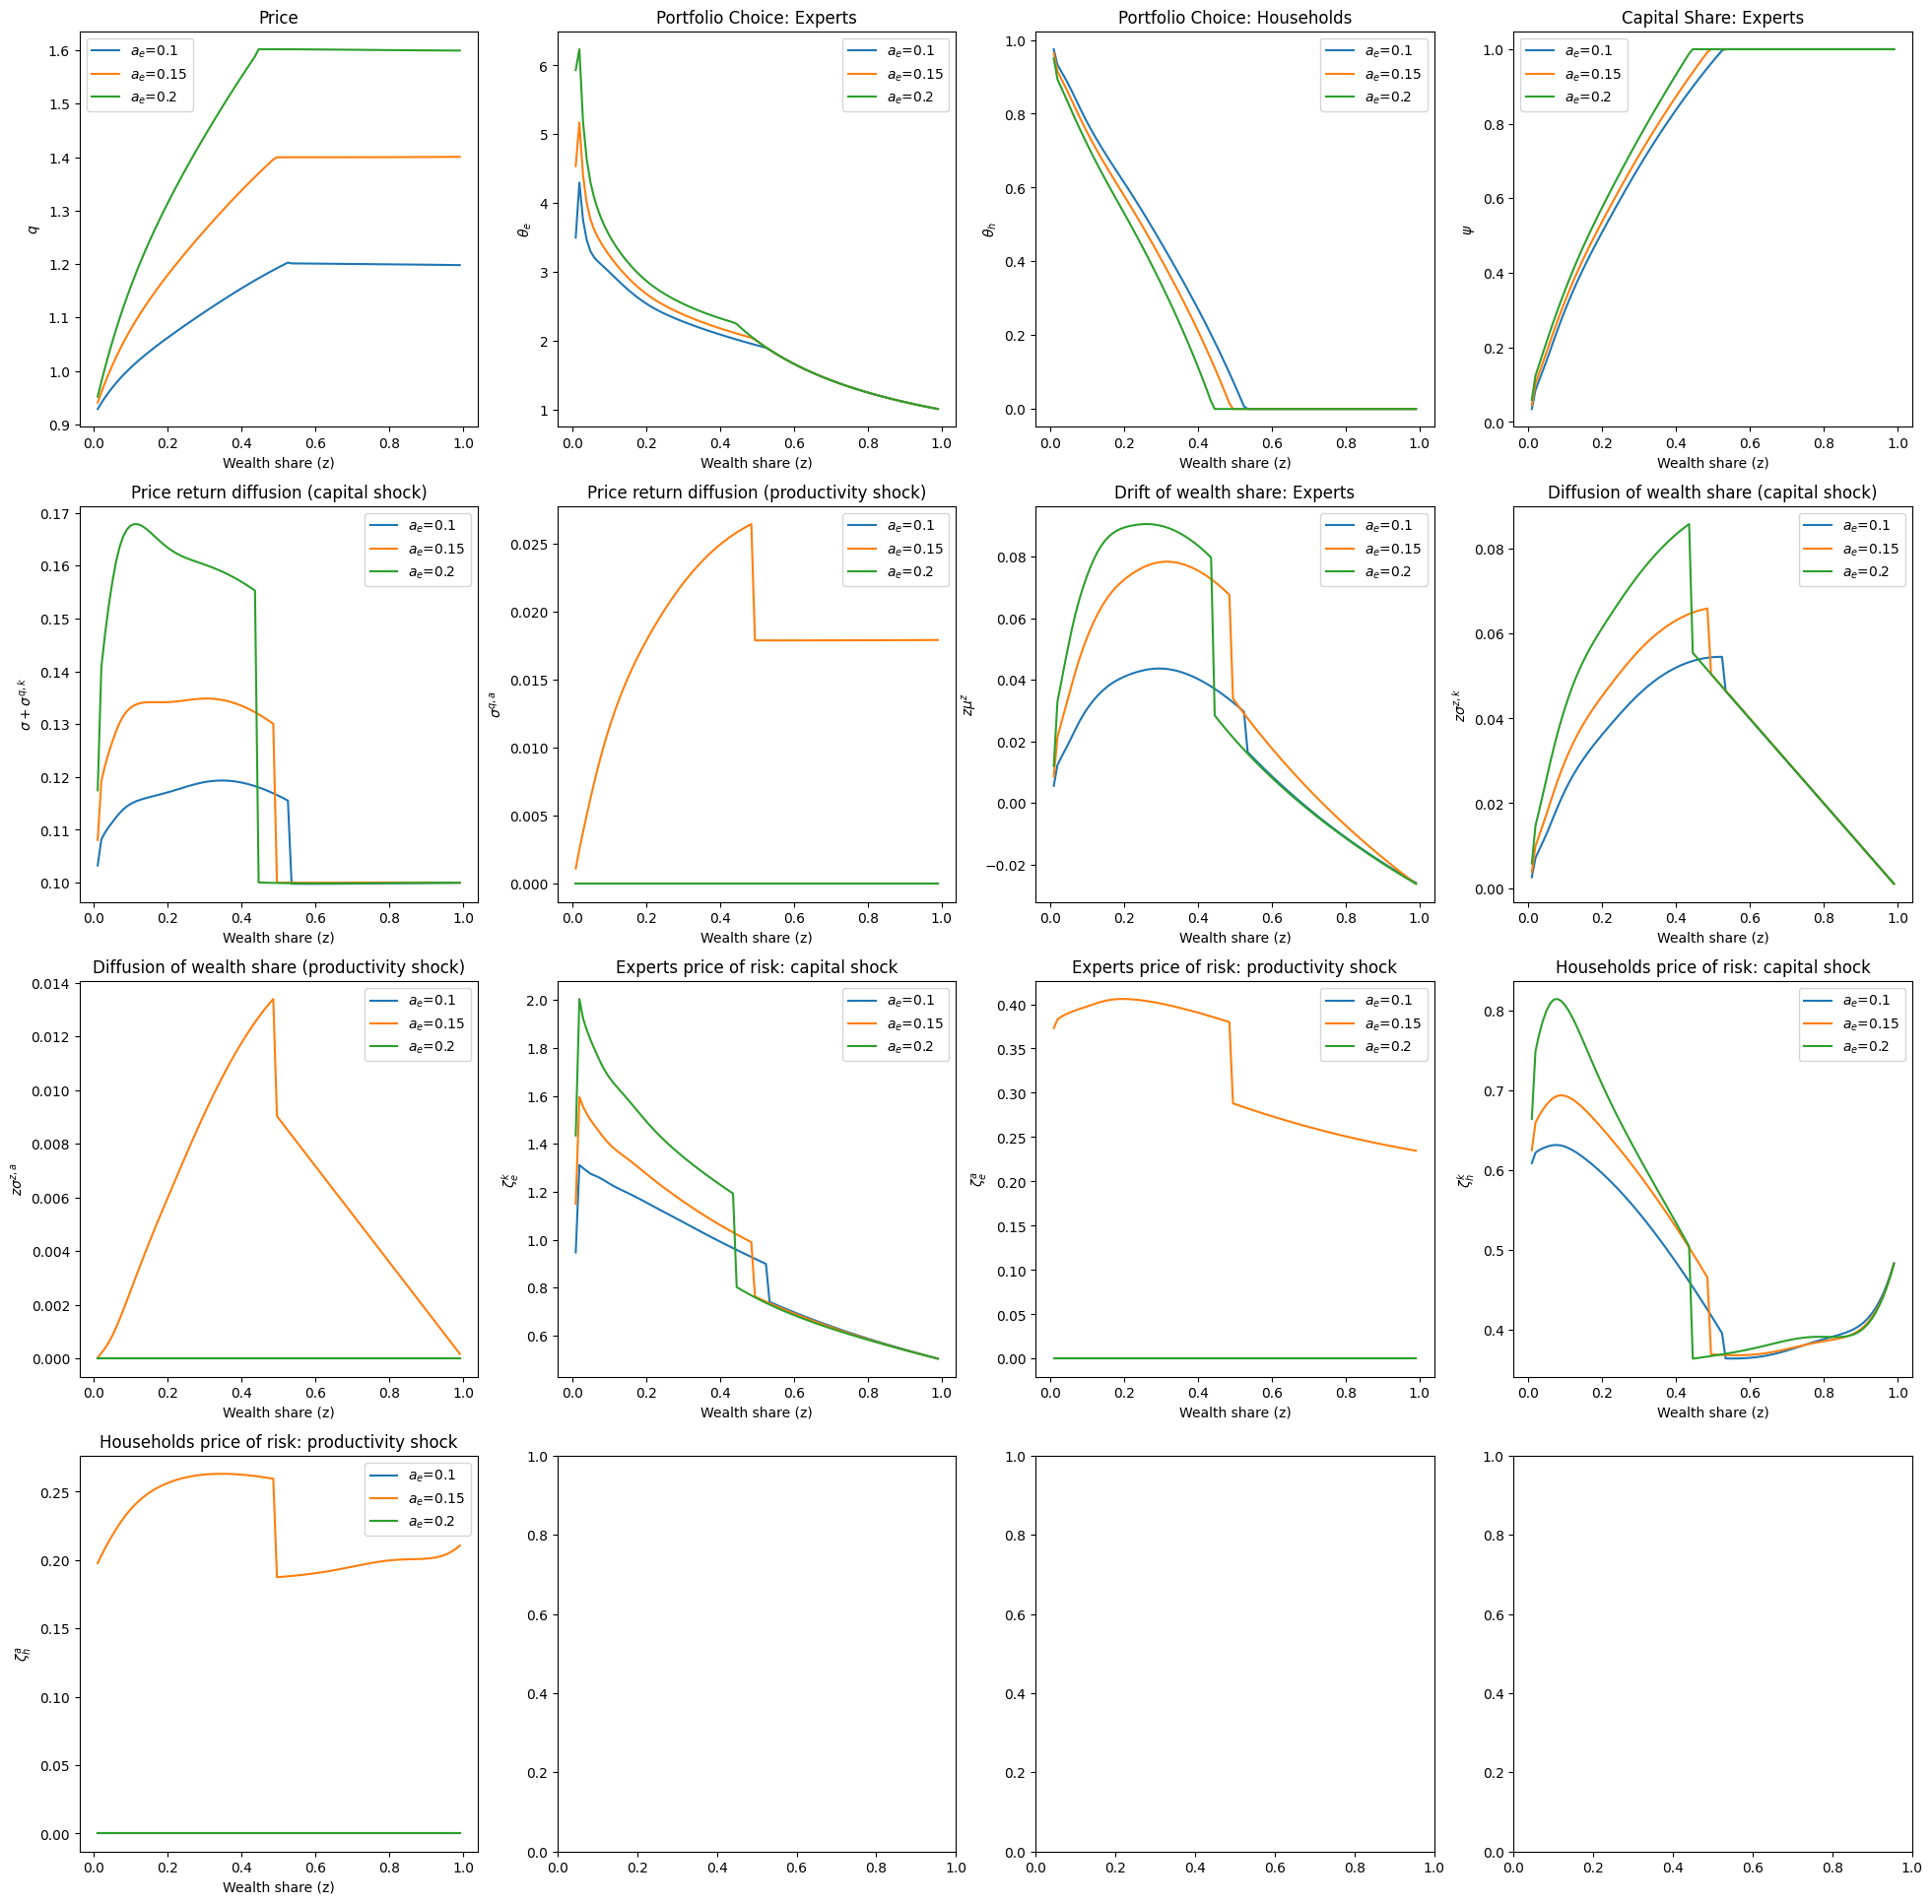

In [8]:
final_plot_dict = {}
for a in a_list:
    index_region1 = (res_dict1[f"psi_{a}"] < 1)
    index_region2 = (res_dict1[f"psi_{a}"] >= 1) & (res_dict2[f"epse_{a}"] > res_dict2[f"epsh_{a}"])
    index_region3 = (res_dict1[f"psi_{a}"] >= 1) & (res_dict2[f"epse_{a}"] <= res_dict2[f"epsh_{a}"])
    for k in plot_args:
        final_plot_dict[f"{k}_{a}"] = res_dict1[f"{k}_{a}"] * index_region1 + res_dict2[f"{k}_{a}"] * index_region2 + res_dict3[f"{k}_{a}"] * index_region3
final_plot_dict["x_plot"] = res_dict1["x_plot"]
plot_res(final_plot_dict, plot_args, a_list)